In [70]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d

# ======================
# 配置
# ======================

REVERSE_COORDS = True   # <<< 控制是否反转坐标及对应属性
# ======================
TARGET_N = 64  # 目标采样点数

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)


def read_vtk_point_cell_data(filepath, resampling_num = 100):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    # 提取曲线坐标
    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])
    resampled_coords = resample_array(coords, resampling_num)

    # 读取并插值 point data
    pd = polydata.GetPointData()
    point_data = {}
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):
                resampled = resample_array(data, resampling_num)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data

    # 额外提取 curvature / torsion / lab（若存在）
    for key in ["Curvature", "Torsion", "Lab"]:
        if key not in point_data and pd.HasArray(key):
            arr = numpy_support.vtk_to_numpy(pd.GetArray(key))
            point_data[key] = resample_array(arr, resampling_num)

    # cell data（可选）
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    # === 若开启反转模式 ===
    if REVERSE_COORDS:
        resampled_coords = np.flip(resampled_coords, axis=0)
        for k, v in point_data.items():
            if isinstance(v, np.ndarray) and v.shape[0] == TARGET_N:
                point_data[k] = np.flip(v, axis=0)

    return point_data, cell_data, resampled_coords


def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path, resampling_num=TARGET_N)
            results[fname] = {
                "point_data": point_data,
                "cell_data": cell_data,
                "coords": coords
            }
    return results


# === 设置路径并加载 ===
base_dir = r"D:\!BraVa_src\ica_results\siphon"
vtk_data_dict = batch_read_vtk_data(base_dir)

# # 平移坐标使起点在原点
# for name in vtk_data_dict:
#     coords = vtk_data_dict[name]["coords"]
#     vtk_data_dict[name]["coords"] = coords - coords[0]

print(f"✅ Loaded {len(vtk_data_dict)} curves; each resampled to {TARGET_N} points.")
print(f"✅ Coordinate reversed: {REVERSE_COORDS}")
print(f"✅ Example keys in point_data: {list(vtk_data_dict[list(vtk_data_dict.keys())[0]]['point_data'].keys())}")


✅ Loaded 77 curves; each resampled to 64 points.
✅ Coordinate reversed: True
✅ Example keys in point_data: ['MaximumInscribedSphereRadius', 'curvature', 'torsion', 'lab']


In [71]:
# ======================
# 读取 Original Centerline 并配对
# ======================

original_base_dir = r"D:\!BraVa_src\ica_results\Feng\1_Data\1_Brava\1_Centerline\2_Original(from feng)"

matched_count = 0
missing_count = 0

print("Start matching and loading original centerlines...")

# 遍历现有的 siphon 数据字典
for siphon_fname in vtk_data_dict.keys():
    # 1. 解析文件名
    # 假设文件名格式为: BG0001_L_siphon_lab.vtk
    # parts -> ['BG0001', 'L', 'siphon', 'lab.vtk']
    parts = siphon_fname.split('_')
    
    if len(parts) < 2:
        print(f"⚠️ Skipping matching for unexpected filename format: {siphon_fname}")
        continue
        
    subject_id = parts[0]  # e.g., BG0001
    side = parts[1]        # e.g., L
    
    # 2. 构建目标文件名
    # 目标格式: BG0001_ICA_L.vtk
    target_fname = f"{subject_id}_ICA_{side}.vtk"
    target_path = os.path.join(original_base_dir, target_fname)
    
    # 3. 检查文件是否存在并读取
    if os.path.exists(target_path):
        # 注意：这里调用了上一个cell定义的 read_vtk_point_cell_data
        # 这意味着 REVERSE_COORDS 和 TARGET_N 的设置也会应用在这些文件上
        pt_data, cell_data, coords = read_vtk_point_cell_data(target_path, resampling_num=120)
        
        # 4. 平移坐标 (归一化起点，保持与 siphon 数据处理一致)
        # coords = coords - coords[0]
        
        # 5. 将数据存入 vtk_data_dict 的对应条目下
        # 我们在原有的字典值中增加一个键 'original_data' 来存放配对数据
        vtk_data_dict[siphon_fname]["original_data"] = {
            "coords": coords,
            "point_data": pt_data,
            "cell_data": cell_data,
            "filename": target_fname
        }
        matched_count += 1
    else:
        print(f"❌ Match not found: {target_fname} (for {siphon_fname})")
        missing_count += 1

print("-" * 30)
print(f"✅ Processing complete.")
print(f"   Matched: {matched_count}")
print(f"   Missing: {missing_count}")

# 验证一下数据结构
if matched_count > 0:
    first_key = list(vtk_data_dict.keys())[0]
    if "original_data" in vtk_data_dict[first_key]:
        print(f"\nExample structure for {first_key}:")
        print(f"   ['coords'].shape: {vtk_data_dict[first_key]['coords'].shape} (Siphon)")
        print(f"   ['original_data']['coords'].shape: {vtk_data_dict[first_key]['original_data']['coords'].shape} (Original)")

Start matching and loading original centerlines...
------------------------------
✅ Processing complete.
   Matched: 77
   Missing: 0

Example structure for BG0001_L_siphon_lab.vtk:
   ['coords'].shape: (64, 3) (Siphon)
   ['original_data']['coords'].shape: (120, 3) (Original)


In [72]:
import pandas as pd
import os

# === 分类表路径 ===
category_csv = r"D:\!BraVa_src\ica_results\siphon\category\classified_centerlines_BestDrop.csv"

# 读取 CSV
df_category = pd.read_csv(category_csv)

# 将 β 列重命名为 beta
df_category = df_category.rename(columns={"β": "beta", "Filename": "filename"})

# 建立一个快速查找字典 {filename: row_dict}
category_dict = {
    row["filename"]: {
        "CR_B1": row["CR_B1"],
        "CR_B2": row["CR_B2"],
        "beta": row["beta"],
        "Type": row["Type"]
    }
    for _, row in df_category.iterrows()
}

# === 合并进 vtk_data_dict ===
for name in vtk_data_dict:
    # 去掉扩展名（假设键名形如 BG0001_L_siphon_lab.vtk）
    key = os.path.splitext(name)[0]
    if key in category_dict:
        vtk_data_dict[name]["category_info"] = category_dict[key]
    else:
        vtk_data_dict[name]["category_info"] = None  # 若分类表中没有，置空

print(f"✅ Merged category info for {sum(v is not None for v in category_dict.values())} entries.")


✅ Merged category info for 77 entries.


In [73]:
# 获取第一个 key
sample_key = list(vtk_data_dict.keys())[0]
sample_data = vtk_data_dict[sample_key]

print(f"📂 Sample File: {sample_key}")
print("-" * 30)

# 1. 检查 Siphon 数据
print(f"🔹 Siphon Coords Shape: {sample_data['coords'].shape}")

# 2. 检查 Original 数据
if "original_data" in sample_data:
    print(f"🔹 Original File: {sample_data['original_data']['filename']}")
    print(f"   Original Coords Shape: {sample_data['original_data']['coords'].shape}")
else:
    print("🔸 No Original Data linked.")

# 3. 检查 Category 数据
if sample_data["category_info"]:
    print(f"🔹 Category Info: {sample_data['category_info']}")
else:
    print("🔸 Category Info is None (Not found in CSV).")

📂 Sample File: BG0001_L_siphon_lab.vtk
------------------------------
🔹 Siphon Coords Shape: (64, 3)
🔹 Original File: BG0001_ICA_L.vtk
   Original Coords Shape: (120, 3)
🔹 Category Info: {'CR_B1': 1.6786, 'CR_B2': 3.8594, 'beta': 45.1, 'Type': 'U'}


⏳ Preparing dataset (Projecting Siphon onto Original)...
✅ Dataset prepared. Total samples: 77

🚀 Start Training on cuda...
   Train samples (Augmented): 61
   Test samples (Clean): 16
   Epoch [20/150], Loss: 0.001672
   Epoch [40/150], Loss: 0.000945
   Epoch [60/150], Loss: 0.000938
   Epoch [80/150], Loss: 0.000786
   Epoch [100/150], Loss: 0.000888
   Epoch [120/150], Loss: 0.000778
   Epoch [140/150], Loss: 0.000700


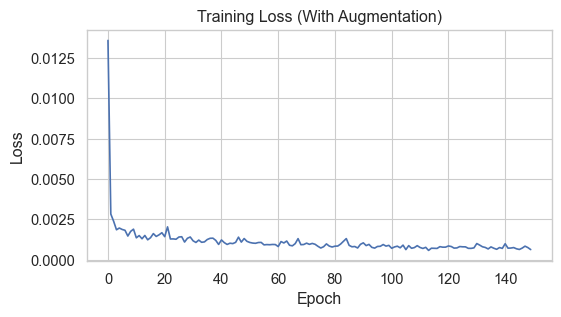


📊 Visualization of Test Results:


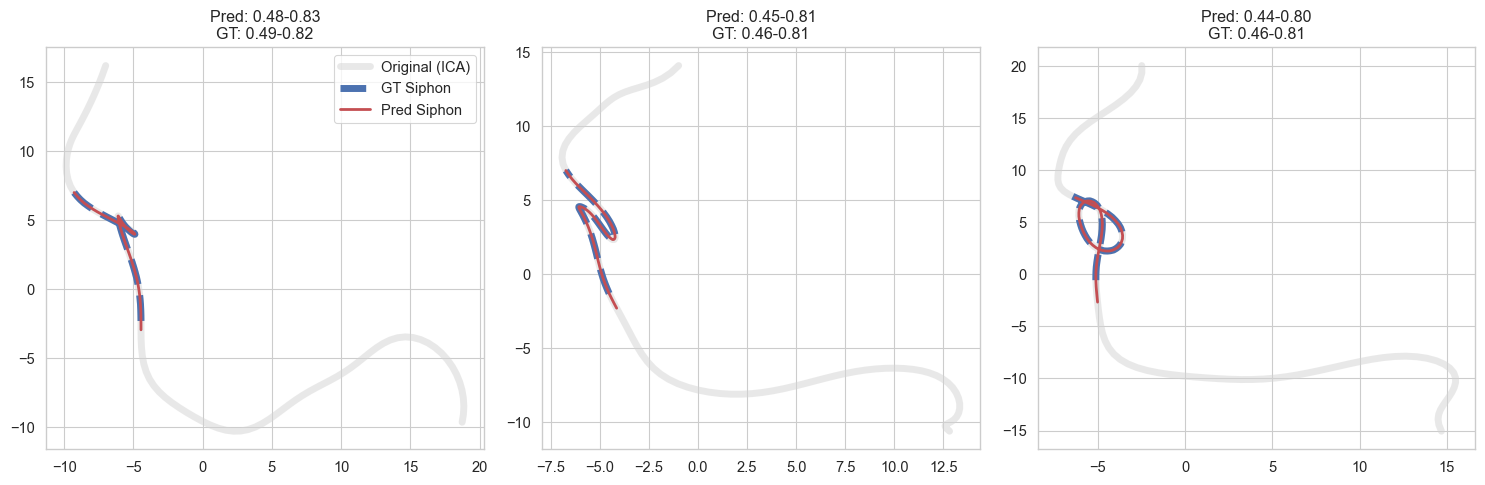

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ============================
# 0. 定义增强工具 (NEW)
# ============================
class CurveAugmenter:
    def __init__(self, rotation_range=30, scale_range=(0.85, 1.15), noise_std=0.005, flip_prob=0.5):
        self.rot_range = np.deg2rad(rotation_range)
        self.scale_range = scale_range
        self.noise_std = noise_std
        self.flip_prob = flip_prob

    def random_rotation_matrix(self):
        rx, ry, rz = np.random.uniform(-self.rot_range, self.rot_range, 3)
        Rx = np.array([[1, 0, 0], [0, np.cos(rx), -np.sin(rx)], [0, np.sin(rx), np.cos(rx)]])
        Ry = np.array([[np.cos(ry), 0, np.sin(ry)], [0, 1, 0], [-np.sin(ry), 0, np.cos(ry)]])
        Rz = np.array([[np.cos(rz), -np.sin(rz), 0], [np.sin(rz), np.cos(rz), 0], [0, 0, 1]])
        return Rz @ Ry @ Rx

    def __call__(self, coords):
        augmented = coords.copy()
        # 1. 旋转
        R = self.random_rotation_matrix()
        augmented = np.dot(augmented, R.T)
        # 2. 缩放
        scale = np.random.uniform(*self.scale_range)
        augmented *= scale
        # 3. 翻转 (X轴镜像)
        if np.random.random() < self.flip_prob:
            augmented[:, 0] *= -1
        # 4. 噪声
        noise = np.random.normal(0, self.noise_std, augmented.shape)
        augmented += noise
        return augmented.astype(np.float32)

class VascularDataset(Dataset):
    def __init__(self, x_data, y_data, augment=False):
        self.x_data = x_data # List of arrays
        self.y_data = y_data # List of arrays
        self.augment = augment
        self.augmenter = CurveAugmenter()

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        coords = self.x_data[idx]
        target = self.y_data[idx]

        if self.augment:
            coords = self.augmenter(coords)
        
        # 转换为 Tensor 并调整维度 (120, 3) -> (3, 120)
        coords_tensor = torch.from_numpy(coords).float().permute(1, 0)
        target_tensor = torch.from_numpy(np.array(target)).float()

        return coords_tensor, target_tensor

# ============================
# 1. 数据准备与标签生成
# ============================
print("⏳ Preparing dataset (Projecting Siphon onto Original)...")

# 注意：这里我们只收集 List，不再直接转 Tensor，等到 DataLoader 取数据时再转
X_data_list = [] 
Y_data_list = []

def get_projection_ratio(original_curve, point):
    dists = np.linalg.norm(original_curve - point, axis=1)
    min_idx = np.argmin(dists)
    return min_idx / (len(original_curve) - 1)

for key, val in vtk_data_dict.items():
    if "original_data" not in val:
        continue
        
    siphon_coords = val['coords']
    original_coords = val['original_data']['coords']
    
    p_start = siphon_coords[0]
    p_end = siphon_coords[-1]
    
    t_start = get_projection_ratio(original_coords, p_start)
    t_end = get_projection_ratio(original_coords, p_end)
    
    if t_start > t_end:
        t_start, t_end = t_end, t_start
        
    centroid = np.mean(original_coords, axis=0)
    norm_original = original_coords - centroid
    
    X_data_list.append(norm_original.astype(np.float32))
    Y_data_list.append([t_start, t_end])

print(f"✅ Dataset prepared. Total samples: {len(X_data_list)}")

# ============================
# 2. 定义模型 (保持不变)
# ============================
class SiphonLocator(nn.Module):
    def __init__(self):
        super(SiphonLocator, self).__init__()
        # Input: (Batch, 3, 120)
        self.features = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # 120 -> 60
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # 60 -> 30
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)  # 30 -> 15
        )
        # Flatten: 128 * 15 = 1920
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.features(x)
        return self.regressor(feat)

# ============================
# 3. 训练流程 (引入增强与拆分)
# ============================
# 手动拆分索引
total_len = len(X_data_list)
train_len = int(0.8 * total_len)
indices = np.arange(total_len)
np.random.shuffle(indices)

train_indices = indices[:train_len]
test_indices = indices[train_len:]

# 创建两个独立的 Dataset 实例
# 训练集：开启增强 (augment=True)
train_dataset = VascularDataset(
    [X_data_list[i] for i in train_indices],
    [Y_data_list[i] for i in train_indices],
    augment=True 
)

# 测试集：关闭增强 (augment=False) - 必须评估原始真实数据
test_dataset = VascularDataset(
    [X_data_list[i] for i in test_indices],
    [Y_data_list[i] for i in test_indices],
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiphonLocator().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\n🚀 Start Training on {device}...")
print(f"   Train samples (Augmented): {len(train_dataset)}")
print(f"   Test samples (Clean): {len(test_dataset)}")

epochs = 150 # 增加轮数，因为增强后任务变难了
loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    if (epoch+1) % 20 == 0:
        print(f"   Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Training Loss (With Augmentation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# ============================
# 4. 测试与可视化
# ============================
def extract_siphon_from_original(original_arr, t_s, t_e, target_n=64):
    idx_s = int(t_s * (len(original_arr) - 1))
    idx_e = int(t_e * (len(original_arr) - 1))
    if idx_s >= idx_e: idx_e = idx_s + 1
    idx_e = min(idx_e, len(original_arr)-1)
    segment = original_arr[idx_s:idx_e+1]
    if len(segment) < 2: return np.repeat(segment, target_n, axis=0)
    orig_steps = np.linspace(0, 1, len(segment))
    target_steps = np.linspace(0, 1, target_n)
    f = interp1d(orig_steps, segment, axis=0, kind='linear')
    return f(target_steps)

print("\n📊 Visualization of Test Results:")
model.eval()

fig = plt.figure(figsize=(15, 5))
# 从测试集中随机取样
if len(test_dataset) > 0:
    indices_to_plot = np.random.choice(len(test_dataset), min(3, len(test_dataset)), replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices_to_plot):
            input_tensor, label_tensor = test_dataset[idx] # 这里 input 已经是 (3, 120)
            
            # 预测
            pred = model(input_tensor.unsqueeze(0).to(device)).cpu().numpy()[0]
            pred_start, pred_end = pred[0], pred[1]
            
            # 真实标签
            true_start, true_end = label_tensor.numpy()
            
            # 为了画图，需要转回 numpy 且 shape (120, 3)
            original_centered = input_tensor.permute(1, 0).numpy()
            
            # 重建
            pred_siphon = extract_siphon_from_original(original_centered, pred_start, pred_end, target_n=64)
            true_siphon = extract_siphon_from_original(original_centered, true_start, true_end, target_n=64)
            
            ax = fig.add_subplot(1, 3, i+1)
            ax.plot(original_centered[:,0], original_centered[:,1], 'lightgray', lw=5, alpha=0.5, label='Original (ICA)')
            ax.plot(true_siphon[:,0], true_siphon[:,1], 'b--', lw=5, label='GT Siphon')
            ax.plot(pred_siphon[:,0], pred_siphon[:,1], 'r-', lw=2, label='Pred Siphon')
            
            ax.set_title(f"Pred: {pred_start:.2f}-{pred_end:.2f}\nGT: {true_start:.2f}-{true_end:.2f}")
            if i == 0: ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("❌ Test set is empty.")

In [93]:
from sklearn.model_selection import KFold
import numpy as np
import torch
from torch.utils.data import DataLoader

# ============================
# 配置
# ============================
K_FOLDS = 5
EPOCHS_PER_FOLD = 100  # 增加一点轮数，因为数据增强会让收敛稍慢
BATCH_SIZE = 8
LR = 0.001

# 准备 KFold 分割器
# 我们基于样本索引进行分割
indices = np.arange(len(X_data_list))
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# 用于存储每一折的结果
results = {}

print(f"🚀 Starting {K_FOLDS}-Fold Cross-Validation with Data Augmentation...")

# 注意：这里需要依赖上一步生成的 X_data_list 和 Y_data_list
# 它们是纯粹的 List，还没有被封装进 Dataset

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
    print(f"\n--- Fold {fold + 1}/{K_FOLDS} ---")
    
    # ==========================================
    # 关键修改点：分别为训练和验证构建 Dataset
    # ==========================================
    
    # 1. 根据索引提取数据
    x_train_fold = [X_data_list[i] for i in train_idx]
    y_train_fold = [Y_data_list[i] for i in train_idx]
    
    x_val_fold = [X_data_list[i] for i in val_idx]
    y_val_fold = [Y_data_list[i] for i in val_idx]
    
    # 2. 实例化 Dataset
    # 训练集 -> 开启增强 (augment=True)
    train_ds = VascularDataset(x_train_fold, y_train_fold, augment=True)
    
    # 验证集 -> 关闭增强 (augment=False) <- 严谨评估
    val_ds = VascularDataset(x_val_fold, y_val_fold, augment=False)
    
    # 3. 创建 DataLoader
    trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(val_ds, batch_size=1, shuffle=False)
    
    # 4. 重新初始化模型
    model = SiphonLocator().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    
    # ==========================================
    # 训练循环 (保持不变)
    # ==========================================
    model.train()
    for epoch in range(EPOCHS_PER_FOLD):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

    # ==========================================
    # 评估当前 Fold (保持不变)
    # ==========================================
    model.eval()
    val_loss = 0.0
    absolute_errors = [] 
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            diff = torch.abs(outputs - labels).cpu().numpy()
            absolute_errors.append(diff)

    avg_val_loss = val_loss / len(testloader.dataset)
    mean_abs_error = np.mean(absolute_errors) 
    
    print(f"✅ Fold {fold + 1} Result -> MSE Loss: {avg_val_loss:.6f} | Mean Abs Error: {mean_abs_error:.4f}")
    
    results[fold] = {
        'loss': avg_val_loss,
        'mae': mean_abs_error
    }

# ============================
# 总结
# ============================
print("\n" + "="*30)
print("📊 Cross-Validation Summary (Augmented Training)")
print("="*30)
avg_mae = np.mean([res['mae'] for res in results.values()])
std_mae = np.std([res['mae'] for res in results.values()])

print(f"Average MAE across {K_FOLDS} folds: {avg_mae:.4f}")
print(f"Std Dev (Stability): {std_mae:.4f}")
print("-" * 30)
print(f"这意味着：即便加入了数据增强，模型在未见过的真实数据上的")
print(f"平均定位偏差大约是 {avg_mae*100:.2f}%。")

🚀 Starting 5-Fold Cross-Validation with Data Augmentation...

--- Fold 1/5 ---
✅ Fold 1 Result -> MSE Loss: 0.000642 | Mean Abs Error: 0.0197

--- Fold 2/5 ---
✅ Fold 2 Result -> MSE Loss: 0.003347 | Mean Abs Error: 0.0353

--- Fold 3/5 ---
✅ Fold 3 Result -> MSE Loss: 0.000812 | Mean Abs Error: 0.0228

--- Fold 4/5 ---
✅ Fold 4 Result -> MSE Loss: 0.000605 | Mean Abs Error: 0.0199

--- Fold 5/5 ---
✅ Fold 5 Result -> MSE Loss: 0.000725 | Mean Abs Error: 0.0210

📊 Cross-Validation Summary (Augmented Training)
Average MAE across 5 folds: 0.0237
Std Dev (Stability): 0.0059
------------------------------
这意味着：即便加入了数据增强，模型在未见过的真实数据上的
平均定位偏差大约是 2.37%。


🏆 Training Final Model on 100% Data (with Augmentation)...
   Epoch [20/150], Loss: 0.001206
   Epoch [40/150], Loss: 0.000992
   Epoch [60/150], Loss: 0.000925
   Epoch [80/150], Loss: 0.000797
   Epoch [100/150], Loss: 0.001021
   Epoch [120/150], Loss: 0.000756
   Epoch [140/150], Loss: 0.000756
✅ Final Model Trained.
💾 Model saved to: siphon_locator_best.pth


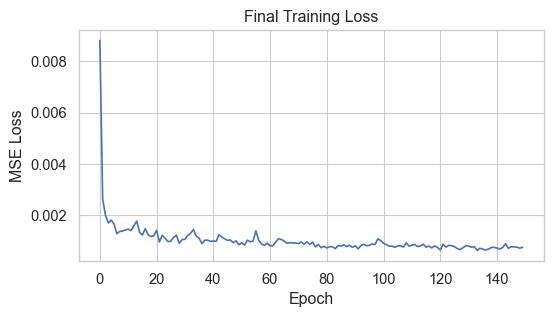

In [94]:
# ============================
# 1. 使用 100% 数据 + 增强 训练最终模型
# ============================
print("🏆 Training Final Model on 100% Data (with Augmentation)...")

# 使用全部数据构建 Dataset，并且开启增强！
# 这样模型能见识到最多的变化
full_dataset = VascularDataset(X_data_list, Y_data_list, augment=True)
full_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

# 重新初始化模型
final_model = SiphonLocator().to(device)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 增加训练轮数
# 经验：数据增强会让收敛变慢，所以我们把 Epoch 增加到 150 或 200
FINAL_EPOCHS = 150 

final_model.train()
loss_history = []

for epoch in range(FINAL_EPOCHS):
    running_loss = 0.0
    for inputs, labels in full_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    avg_loss = running_loss / len(full_dataset)
    loss_history.append(avg_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"   Epoch [{epoch+1}/{FINAL_EPOCHS}], Loss: {avg_loss:.6f}")

print("✅ Final Model Trained.")

# ============================
# 2. 保存模型权重
# ============================
save_path = "siphon_locator_best.pth"
torch.save(final_model.state_dict(), save_path)
print(f"💾 Model saved to: {save_path}")

# 画一下 Loss 确认收敛
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Final Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

✅ Predictor loaded from siphon_locator_best.pth

🔮 Prediction Result:
   Range: 50.6% - 84.0%
   Siphon Shape: (64, 3)


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\3989632817.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



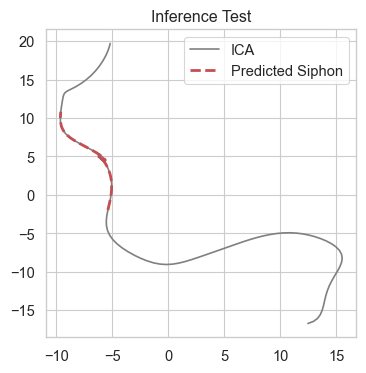

In [ ]:
class SiphonPredictor:
    def __init__(self, model_path, device='cpu'):
        self.device = device
        
        # 初始化模型结构
        self.model = SiphonLocator().to(self.device)
        
        # 加载权重
        state_dict = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        self.model.eval()
        print(f"✅ Predictor loaded from {model_path}")

    def predict(self, original_coords, output_points=64):
        """
        original_coords: (N, 3) numpy array, 原始 ICA 坐标
        output_points: 输出 Siphon 的点数
        
        Return: 
            siphon_coords: (output_points, 3)
            (t_start, t_end): 在原始曲线上的比例位置
        """
        # 1. 预处理：重采样到 120 点 (模型输入要求)
        target_input_len = 120
        if len(original_coords) != target_input_len:
            x_old = np.linspace(0, 1, len(original_coords))
            x_new = np.linspace(0, 1, target_input_len)
            f = interp1d(x_old, original_coords, kind='linear', axis=0, fill_value="extrapolate")
            resampled_input = f(x_new)
        else:
            resampled_input = original_coords

        # 2. 预处理：重心归一化
        centroid = np.mean(resampled_input, axis=0)
        norm_input = resampled_input - centroid
        
        # 3. 转 Tensor (1, 3, 120)
        input_tensor = torch.from_numpy(norm_input).float()
        input_tensor = input_tensor.permute(1, 0).unsqueeze(0).to(self.device)
        
        # 4. 推理
        with torch.no_grad():
            preds = self.model(input_tensor).cpu().numpy()[0]
        
        t_start, t_end = preds[0], preds[1]
        
        # 5. 后处理：从原始数据截取
        siphon_coords = self._extract_siphon(original_coords, t_start, t_end, output_points)
        
        return siphon_coords, (t_start, t_end)

    def _extract_siphon(self, original_arr, t_s, t_e, target_n):
        # 内部辅助函数
        idx_s = int(t_s * (len(original_arr) - 1))
        idx_e = int(t_e * (len(original_arr) - 1))
        if idx_s >= idx_e: idx_e = idx_s + 1
        idx_e = min(idx_e, len(original_arr)-1)
        segment = original_arr[idx_s:idx_e+1]
        if len(segment) < 2: return np.repeat(segment, target_n, axis=0)
        orig_steps = np.linspace(0, 1, len(segment))
        target_steps = np.linspace(0, 1, target_n)
        f = interp1d(orig_steps, segment, axis=0, kind='linear')
        return f(target_steps)

# # === 测试一下 ===
# predictor = SiphonPredictor("siphon_locator_best.pth", device=device)

# # 拿一个数据来模拟新病人
# test_idx = 0
# # 还原回原始坐标（模拟读取了新文件）
# # 注意：这里我们只能拿到归一化后的数据模拟，实际使用直接传 vtk 读取的 coords 即可
# mock_new_patient_data = X_data_list[test_idx] 

# siphon, (ts, te) = predictor.predict(mock_new_patient_data)

# print(f"\n🔮 Prediction Result:")
# print(f"   Range: {ts:.1%} - {te:.1%}")
# print(f"   Siphon Shape: {siphon.shape}")

# # 画图看看
# plt.figure(figsize=(4,4))
# plt.plot(mock_new_patient_data[:,0], mock_new_patient_data[:,1], 'gray', label='ICA')
# plt.plot(siphon[:,0], siphon[:,1], 'r--', lw=2, label='Predicted Siphon')
# plt.legend()
# plt.title("Inference Test")
# plt.show()

C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\3989632817.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



✅ Predictor loaded from siphon_locator_best.pth
📂 Processing 20 files from D:\!_Nagahama_src\20250523_all\20250523_all\002_ICA_vmtk_centerline_geometry...


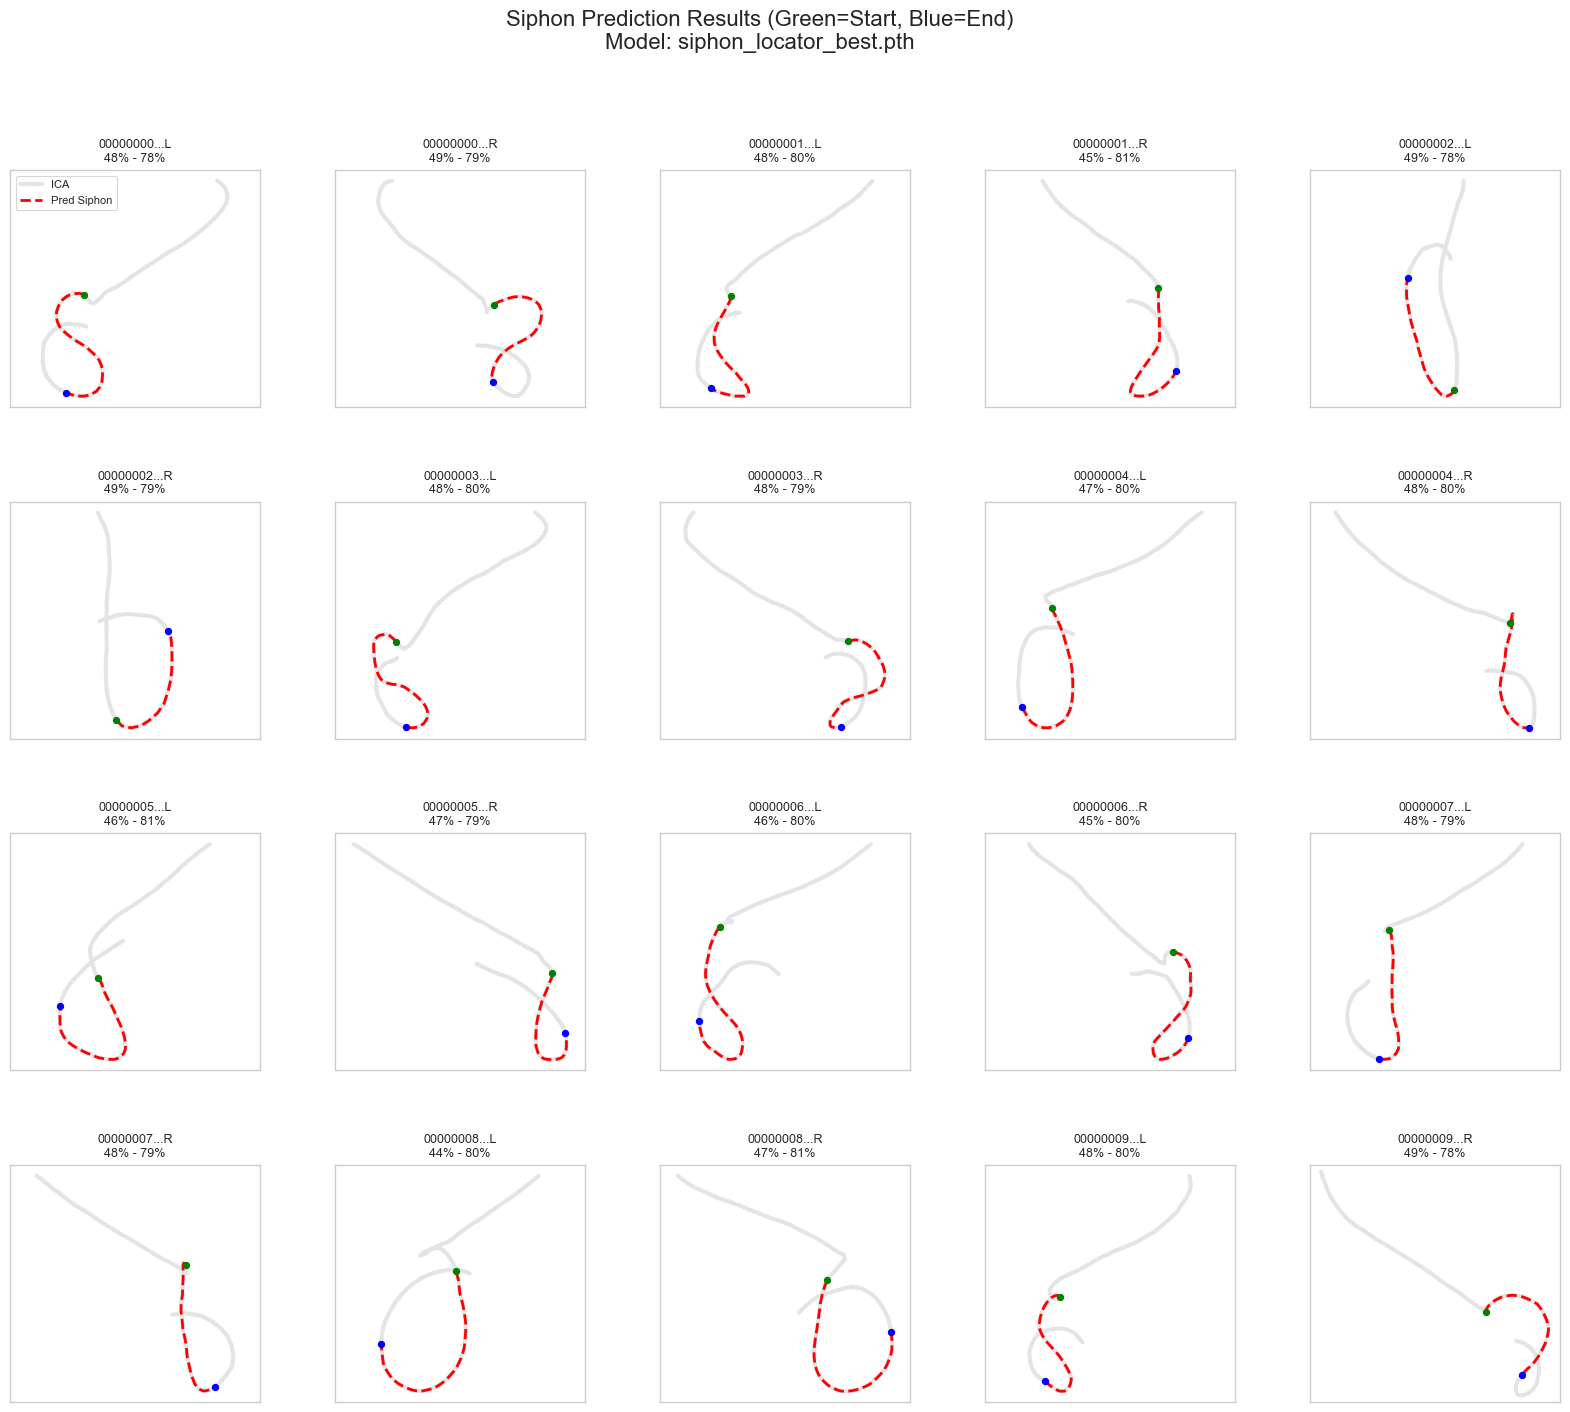

✅ Visualization complete. Displayed 20 samples.


In [96]:
# 导入nagahama中心线，找出siphon位置

import os
import vtk
import torch
import torch.nn as nn  # 必须导入，用于重建模型结构
import numpy as np
import matplotlib.pyplot as plt
from vtk.util import numpy_support
from scipy.interpolate import interp1d

# ============================
# 1. 配置路径与设备
# ============================
NEW_DATA_DIR = r"D:\!_Nagahama_src\20250523_all\20250523_all\002_ICA_vmtk_centerline_geometry"
MODEL_PATH = "siphon_locator_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. 重新定义模型结构 (必须与保存时完全一致)
# ============================
class SiphonLocator(nn.Module):
    def __init__(self):
        super(SiphonLocator, self).__init__()
        # Input: (Batch, 3, 120)
        self.features = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # 120 -> 60
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2), # 60 -> 30
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)  # 30 -> 15
        )
        # Flatten: 128 * 15 = 1920
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1920, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.features(x)
        return self.regressor(feat)

# ============================
# 3. 辅助函数 (复用之前的逻辑)
# ============================
def read_single_vtk_coords(filepath):
    """仅读取坐标，不处理 PointData"""
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()
    
    if polydata.GetNumberOfPoints() == 0:
        return None

    # 优先尝试按连接顺序提取 (GetLines)
    # 很多 centerline 文件的点的存储顺序可能是乱的，必须按 Line Cell 的连接顺序读
    lines = polydata.GetLines()
    if lines.GetNumberOfCells() > 0:
        lines.InitTraversal()
        id_list = vtk.vtkIdList()
        lines.GetNextCell(id_list)
        n_ids = id_list.GetNumberOfIds()
        coords = []
        for i in range(n_ids):
            pid = id_list.GetId(i)
            coords.append(polydata.GetPoint(pid))
        return np.array(coords)
    else:
        # 如果没有 Line Cell，才回退到直接读取 Point 数据
        points = polydata.GetPoints()
        return numpy_support.vtk_to_numpy(points.GetData())

def resample_coords(arr, target_len):
    """简单重采样函数"""
    if len(arr) < 2: return arr
    x_old = np.linspace(0, 1, len(arr))
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

# ============================
# 4. 执行预测与可视化
# ============================

# --- 加载模型 ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

predictor = SiphonPredictor(MODEL_PATH, device=DEVICE)

# --- 获取文件列表 ---
all_files = [f for f in os.listdir(NEW_DATA_DIR) if f.endswith(".vtk")]
# 随机打乱或者取前20个
sample_files = all_files[:20]

print(f"📂 Processing {len(sample_files)} files from {NEW_DATA_DIR}...")

# --- 绘图设置 ---
rows = 4
cols = 5
fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

success_count = 0

for i, fname in enumerate(sample_files):
    full_path = os.path.join(NEW_DATA_DIR, fname)
    
    # 1. 读取原始 ICA
    original_coords = read_single_vtk_coords(full_path)
    
    if original_coords is None or len(original_coords) < 10:
        print(f"⚠️ Skipping {fname}: Too few points or empty.")
        continue
        
    # 重要：检查是否需要反转 (REVERSE_COORDS)
    # 如果你训练时的 ICA 是反转过的（比如从海绵窦到颈部），这里的新数据也必须保持一致的方向。
    # 这里我们暂时假设新数据方向与训练数据一致。如果结果全是错的，请尝试取消下面这行的注释：
    # original_coords = np.flip(original_coords, axis=0)
    
    # 2. 预测 Siphon
    # 注意：predictor 内部会自动重采样到 120 点进行推理，然后映射回原始坐标截取
    try:
        pred_siphon, (t_start, t_end) = predictor.predict(original_coords, output_points=64)
        
        # 3. 可视化
        ax = fig.add_subplot(rows, cols, success_count + 1)
        
        # 为了画图好看，我们把它们投影到 X-Y 平面 (忽略 Z 轴)
        # 也可以尝试 X-Z 或 Y-Z，取决于血管的主要走向
        
        # 画整根 ICA (灰色)
        ax.plot(original_coords[:, 0], original_coords[:, 1], color='lightgray', linewidth=3, alpha=0.6, label='ICA')
        
        # 画预测的 Siphon (红色)
        ax.plot(pred_siphon[:, 0], pred_siphon[:, 1], color='red', linewidth=2, linestyle='--', label='Pred Siphon')
        
        # 标记起点和终点
        ax.scatter(pred_siphon[0, 0], pred_siphon[0, 1], c='green', s=20, zorder=5) # Start
        ax.scatter(pred_siphon[-1, 0], pred_siphon[-1, 1], c='blue', s=20, zorder=5) # End
        
        # 设置标题 (文件名 + 预测比例)
        short_name = fname.split('.')[0] + "..." + fname.split('_')[-2] # 简化文件名显示
        ax.set_title(f"{short_name}\n{t_start:.0%} - {t_end:.0%}", fontsize=9)
        ax.axis('equal')
        
        # 去除坐标轴刻度，只看形状
        ax.set_xticks([])
        ax.set_yticks([])
        
        if success_count == 0:
            ax.legend(fontsize=8)
            
        success_count += 1
        
    except Exception as e:
        print(f"❌ Error processing {fname}: {e}")

plt.suptitle(f"Siphon Prediction Results (Green=Start, Blue=End)\nModel: {MODEL_PATH}", fontsize=16)
plt.show()

print(f"✅ Visualization complete. Displayed {success_count} samples.")

=== 长度统计摘要 (Summary) ===
count    77.000000
mean     25.362099
std       4.376751
min      17.729523
25%      22.453383
50%      25.039484
75%      27.539407
max      45.097450
Name: Length, dtype: float64

=== 各类型长度均值 (Mean Length by Type) ===
Type
C    23.914410
S    23.943789
U    25.941014
V    23.220267
Name: Length, dtype: float64


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\1162120986.py:74: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




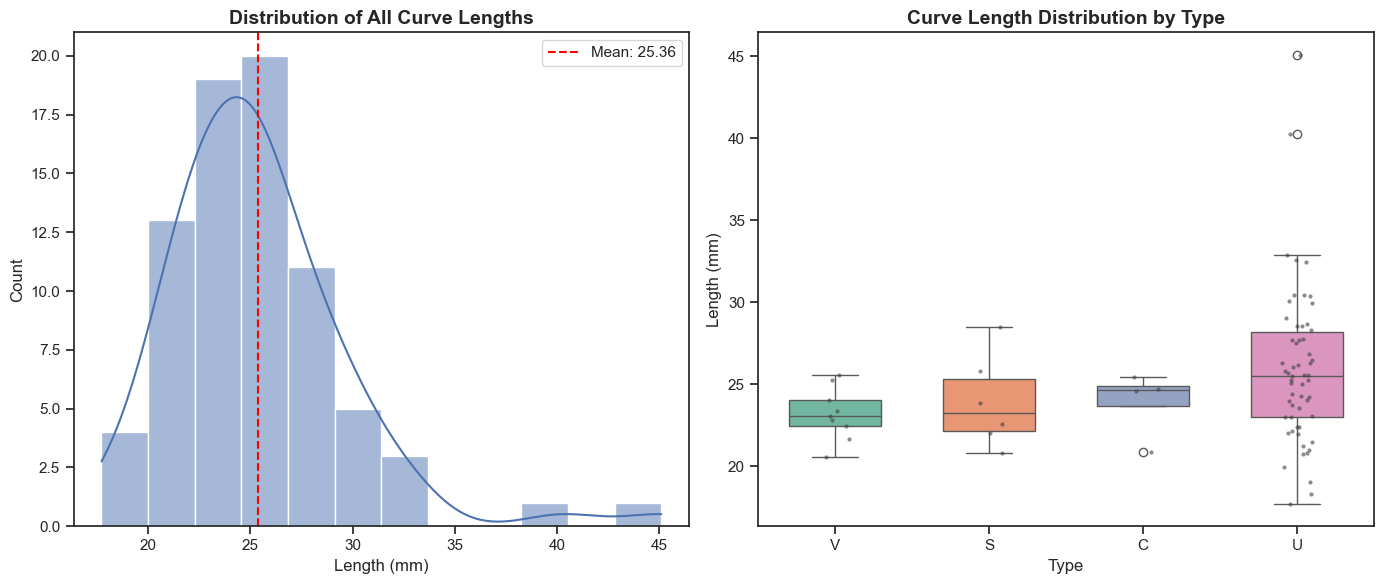

=== 最长的 10 条曲线 ===
Filename                       | Type       | Length (mm)
------------------------------------------------------------
BH0009_R_siphon_lab.vtk        | U          | 45.0975
BG0006_R_siphon_lab.vtk        | U          | 40.2625
BG0010_L_siphon_lab.vtk        | U          | 32.8682
BG0011_L_siphon_lab.vtk        | U          | 32.5760
BG0020_L_siphon_lab.vtk        | U          | 32.4420
BH0039_R_siphon_lab.vtk        | U          | 30.4543
BG0020_R_siphon_lab.vtk        | U          | 30.4258
BG0018_L_siphon_lab.vtk        | U          | 30.3928
BH0014_R_siphon_lab.vtk        | U          | 30.0970
BH0016_L_siphon_lab.vtk        | U          | 29.9618

文件名列表: ['BH0009_R_siphon_lab.vtk', 'BG0006_R_siphon_lab.vtk', 'BG0010_L_siphon_lab.vtk', 'BG0011_L_siphon_lab.vtk', 'BG0020_L_siphon_lab.vtk', 'BH0039_R_siphon_lab.vtk', 'BG0020_R_siphon_lab.vtk', 'BG0018_L_siphon_lab.vtk', 'BH0014_R_siphon_lab.vtk', 'BH0016_L_siphon_lab.vtk']


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 定义计算长度的函数
# ==========================================
def calculate_curve_length(coords):
    """
    输入: (N, 3) 的坐标数组
    输出: 曲线总弧长
    """
    # 计算相邻点之间的向量差: (x2-x1, y2-y1, z2-z1)
    diffs = np.diff(coords, axis=0)
    # 计算每段的欧几里得距离
    segment_lengths = np.linalg.norm(diffs, axis=1)
    # 累加得到总长
    return np.sum(segment_lengths)

# ==========================================
# 2. 遍历数据并构建 DataFrame
# ==========================================
data_rows = []

for name, data in vtk_data_dict.items():
    coords = data["coords"]
    cat_info = data.get("category_info")
    
    # 计算长度
    length = calculate_curve_length(coords)
    
    # 获取分类 Type (若没有分类信息则标记为 'Unknown')
    ctype = "Unknown"
    if cat_info and isinstance(cat_info, dict) and "Type" in cat_info:
        ctype = cat_info["Type"]
    
    data_rows.append({
        "Filename": name,
        "Length": length,
        "Type": ctype
    })

# 转换为 DataFrame 方便分析
df_lengths = pd.DataFrame(data_rows)

# 打印简单的统计信息
print("=== 长度统计摘要 (Summary) ===")
print(df_lengths["Length"].describe())
print("\n=== 各类型长度均值 (Mean Length by Type) ===")
print(df_lengths.groupby("Type")["Length"].mean())

# ==========================================
# 3. 画图
# ==========================================
# 设置风格
sns.set(style="ticks")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- 图 1: 所有曲线长度分布 (Histogram + KDE) ---
sns.histplot(data=df_lengths, x="Length", kde=True, ax=axes[0], color="#4C72B0", edgecolor="w")
axes[0].set_title("Distribution of All Curve Lengths", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Length (mm)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
# 添加平均值竖线
mean_len = df_lengths["Length"].mean()
axes[0].axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f}')
axes[0].legend()

# --- 图 2: 各 Type 长度分布 (Boxplot) ---
# 计算排序顺序（按中位数从小到大）
order = df_lengths.groupby("Type")["Length"].median().sort_values().index

sns.boxplot(data=df_lengths, x="Type", y="Length", order=order, palette="Set2", ax=axes[1], width=0.6)
# 加上散点 (Strip plot) 以显示样本密度
sns.stripplot(data=df_lengths, x="Type", y="Length", order=order, color=".25", size=3, alpha=0.6, jitter=True, ax=axes[1])

axes[1].set_title("Curve Length Distribution by Type", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Type", fontsize=12)
axes[1].set_ylabel("Length (mm)", fontsize=12)

# 调整布局并保存
plt.tight_layout()
plt.savefig("curve_length_analysis.png", dpi=300)
plt.show()


# === 设置你需要输出的数量 ===
n = 10 

# 方法 1: 使用 nlargest (最简洁)
top_n = df_lengths.nlargest(n, 'Length')

# 方法 2: 先排序再取前 n 个 (经典方法)
# top_n = df_lengths.sort_values(by="Length", ascending=False).head(n)

print(f"=== 最长的 {n} 条曲线 ===")
print(f"{'Filename':<30} | {'Type':<10} | {'Length (mm)':<10}")
print("-" * 60)

for _, row in top_n.iterrows():
    print(f"{row['Filename']:<30} | {row['Type']:<10} | {row['Length']:.4f}")

# 如果你想把这些文件名存成一个列表供后续使用：
top_n_filenames = top_n["Filename"].tolist()
print(f"\n文件名列表: {top_n_filenames}")

In [76]:
# === GPA alignment in the quotient space (rotations + reparametrizations) ===
import os, json
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin
from geomstats.learning.frechet_mean import FrechetMean
from tqdm import tqdm
from datetime import datetime
import plotly.graph_objects as go
from plotly.colors import sample_colorscale

# ----------------------------
# Config
# ----------------------------
# TARGET_N = 100
k_sampling_points = TARGET_N
max_iter = 10
tol = 1e-3
outdir = "aligned_results"
os.makedirs(outdir, exist_ok=True)

assert "vtk_data_dict" in globals(), "请先在上方定义或加载 vtk_data_dict"

# ----------------------------
# Construct manifold
# ----------------------------
M = DiscreteCurvesStartingAtOrigin(ambient_dim=3, k_sampling_points=k_sampling_points)
M.equip_with_group_action(("rotations", "reparametrizations"))
M.equip_with_quotient()

# ----------------------------
# Prepare curves
# ----------------------------
curves0_names = list(vtk_data_dict.keys())
curves0 = []
for name in curves0_names:
    P = gs.array(vtk_data_dict[name]["coords"])
    P_proj = M.projection(P)
    P_norm = M.normalize(P_proj)
    curves0.append(P_norm)

n_curves = len(curves0)
print(f"[Init] {n_curves} curves loaded; each has {k_sampling_points} points.")

# ----------------------------
# GPA iterations
# ----------------------------
template = curves0[0]
last_obj = np.inf
history = []

for it in tqdm(range(1, max_iter + 1), desc="GPA iterations", unit="iter"):
    aligned = []
    for C in tqdm(curves0, desc=f" Iter {it} align", leave=False):
        aligned.append(M.fiber_bundle.align(C, template))

    mean_est = FrechetMean(M)
    mean_est.fit(gs.array(aligned))
    new_template = mean_est.estimate_

    diff = gs.linalg.norm((new_template - template).reshape(-1))
    obj_vals = [M.metric.squared_dist(C, new_template) for C in aligned]
    obj = float(gs.mean(obj_vals))
    history.append((it, float(diff), obj))
    tqdm.write(f"[Iter {it:02d}] Δtemplate={diff:.4e}, mean_sq_dist={obj:.6f}")

    if (abs(float(last_obj) - obj) < tol) and (diff < tol):
        template = new_template
        break

    template = new_template
    last_obj = obj

aligned_final = [M.fiber_bundle.align(C, template) for C in curves0]
aligned_final_dict = {name: gs.array(C) for name, C in zip(curves0_names, aligned_final)}
mean_curve = gs.array(template)

print(f"[Done] {len(history)} iterations; final mean_sq_dist={history[-1][2]:.6f}")

# ----------------------------
# Save results
# ----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = os.path.join(outdir, f"aligned_siphon_{timestamp}.json")
save_dict = {
    "aligned_curves": {name: C.tolist() for name, C in aligned_final_dict.items()},
    "mean_curve": mean_curve.tolist(),
    "history": history,
}
with open(outfile, "w") as f:
    json.dump(save_dict, f)
print(f"[Saved] Alignment results -> {outfile}")

# ----------------------------
# Plotly visualization
# ----------------------------
colors = sample_colorscale("Turbo", np.linspace(0, 1, len(aligned_final_dict)))
fig = go.Figure()
for i, (name, C) in enumerate(aligned_final_dict.items()):
    fig.add_trace(go.Scatter3d(
        x=C[:, 0], y=C[:, 1], z=C[:, 2],
        mode="lines",
        line=dict(width=2, color=colors[i]),
        name=name,
        showlegend=(i == 0)
    ))

fig.add_trace(go.Scatter3d(
    x=mean_curve[:, 0], y=mean_curve[:, 1], z=mean_curve[:, 2],
    mode="lines",
    line=dict(width=6, color="black"),
    name="Mean"
))

fig.update_layout(
    height=600, width=700,
    title="Aligned curves (rotations + reparam)",
    margin=dict(l=0, r=0, t=40, b=0),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    )
)
fig.show()


[Init] 77 curves loaded; each has 64 points.


GPA iterations:  10%|█         | 1/10 [00:47<07:08, 47.56s/iter]

[Iter 01] Δtemplate=6.0016e-01, mean_sq_dist=0.103380


GPA iterations:  20%|██        | 2/10 [01:32<06:09, 46.23s/iter]

[Iter 02] Δtemplate=2.6115e-02, mean_sq_dist=0.100834


GPA iterations:  30%|███       | 3/10 [02:17<05:19, 45.65s/iter]

[Iter 03] Δtemplate=6.2326e-03, mean_sq_dist=0.100803


GPA iterations:  40%|████      | 4/10 [03:03<04:33, 45.56s/iter]

[Iter 04] Δtemplate=1.4969e-03, mean_sq_dist=0.100802


GPA iterations:  40%|████      | 4/10 [03:48<05:42, 57.09s/iter]


[Iter 05] Δtemplate=4.5063e-04, mean_sq_dist=0.100802
[Done] 5 iterations; final mean_sq_dist=0.100802
[Saved] Alignment results -> aligned_results\aligned_siphon_20251209_184722.json


12.9 18:19 正在尝试：注释掉加载siphon和ICA时的平移coords到000操作，看看对齐结果是否不变。
- 好像是没啥区别

12.9 18:43 尝试恢复64点siphon和120点ICA
- PCA累计寄与率没变

Number of aligned curves: 77
Shape of one curve: (63, 3)
Aligned array shape: (77, 63, 3)
Aligned array shape: (77, 63, 3)
Mean curve shape: (63, 3)
[tPCA] Explained variance ratio (first 10 PCs): [0.62459942 0.183435   0.08952867 0.05314842 0.01794794 0.01435282
 0.00654812 0.00391222 0.00267973 0.00144599]


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\425292243.py:63: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\425292243.py:69: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



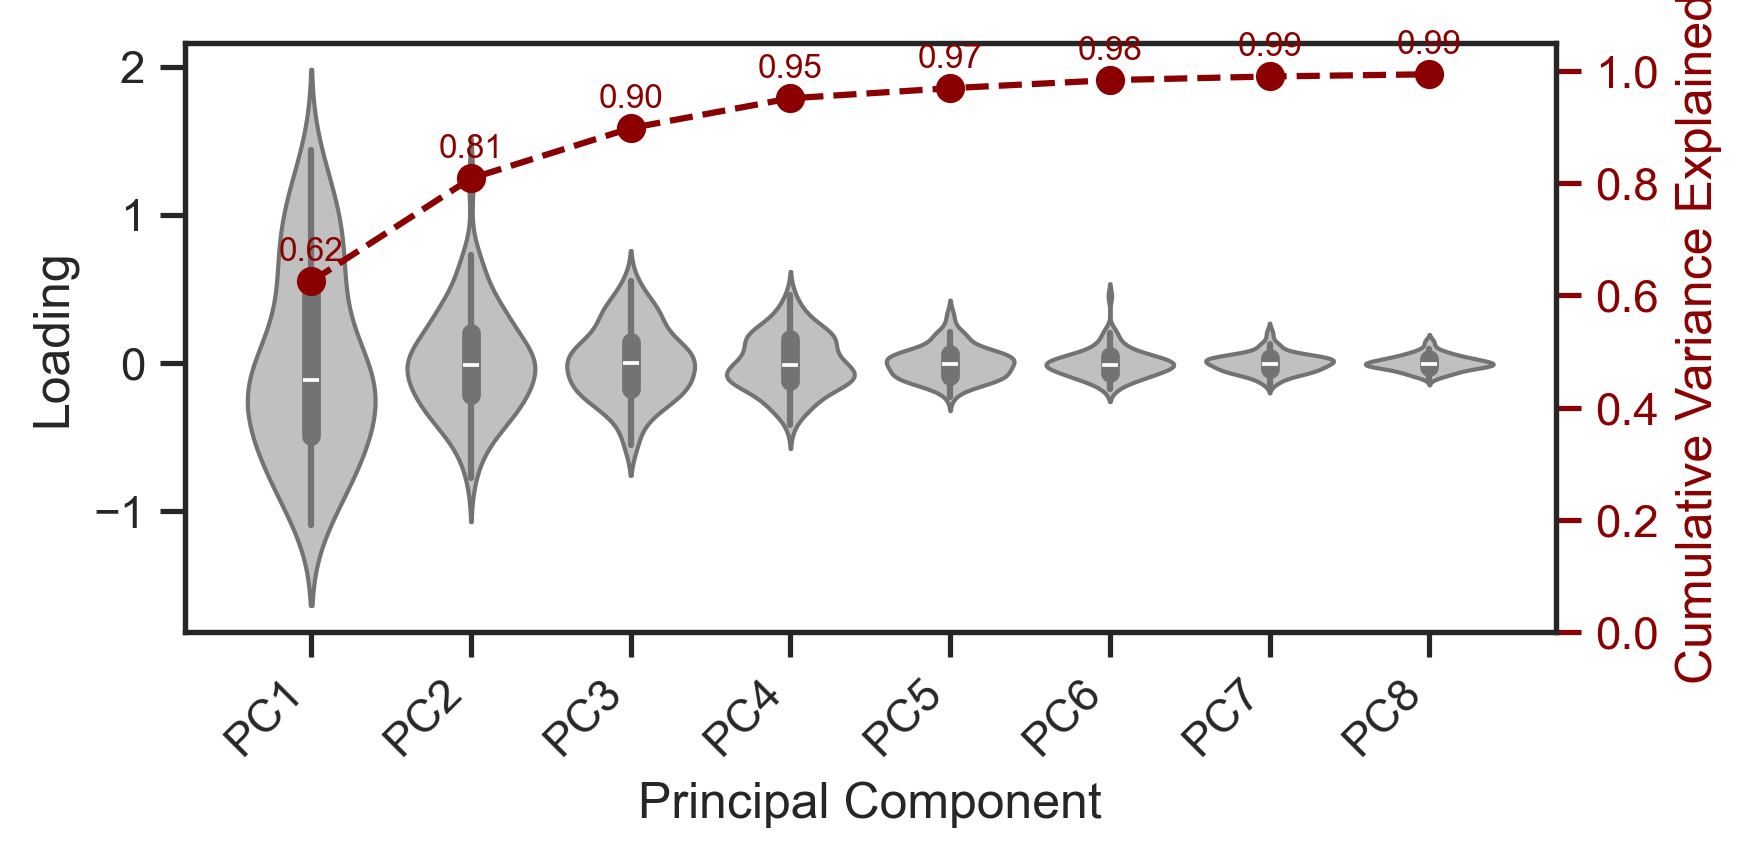


=== Explained Variance per PC ===
  PC  Explained_Variance_Ratio  Cumulative_Variance_Explained
 PC1                  0.624599                       0.624599
 PC2                  0.183435                       0.808034
 PC3                  0.089529                       0.897563
 PC4                  0.053148                       0.950712
 PC5                  0.017948                       0.968659
 PC6                  0.014353                       0.983012
 PC7                  0.006548                       0.989560
 PC8                  0.003912                       0.993473
 PC9                  0.002680                       0.996152
PC10                  0.001446                       0.997598

=== Loadings (first 5 rows) ===
      PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10
-0.441511 -0.013466  0.117664 -0.148068 -0.135157  0.053261 -0.123706  0.020777 -0.037647 -0.015218
-0.446811  0.038144  0.094015 -0.311858 -0.118783 

In [77]:
from geomstats.learning.pca import TangentPCA
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
import geomstats.backend as gs

# === tPCA on aligned curves ===
tPCA_N_COMPONENTS = 10

# Manifold
curves_r3_aligned = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)
curves_r3_aligned.equip_with_metric(SRVMetric)

# 从字典转成 list of arrays
aligned_curves = list(aligned_final_dict.values())
print("Number of aligned curves:", len(aligned_curves))
print("Shape of one curve:", aligned_curves[0].shape)

# 堆叠成 (n_curves, 240, 3)
aligned_curves_array = gs.stack(aligned_curves, axis=0)
print("Aligned array shape:", aligned_curves_array.shape)

print("Aligned array shape:", aligned_curves_array.shape)

# Fréchet mean as base point
mean_aligned = FrechetMean(curves_r3_aligned)
mean_aligned.fit(aligned_curves_array)
mean_curve_aligned = mean_aligned.estimate_
print("Mean curve shape:", mean_curve_aligned.shape)

# Tangent PCA
aligned_tpca = TangentPCA(curves_r3_aligned, n_components=tPCA_N_COMPONENTS)
aligned_tpca.fit(aligned_curves_array, base_point=mean_curve_aligned)
aligned_projected_data = aligned_tpca.transform(aligned_curves_array)

print(f"[tPCA] Explained variance ratio (first 10 PCs): {aligned_tpca.explained_variance_ratio_[:10]}")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 数据准备（前 K=8 个PC）----
explained_variance_ratio = aligned_tpca.explained_variance_ratio_
cumulative_ratio = np.cumsum(explained_variance_ratio)
K = 8

df_long = (
    pd.DataFrame(aligned_projected_data[:, :K],
                 columns=[f"PC{i+1}" for i in range(K)])
      .melt(var_name="PC", value_name="Loading")
)

x_vals = np.arange(K)
labels = [f"PC{i+1}" for i in range(K)]

# ---- 绘图：小提琴 + 累计解释率 ----
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(
    data=df_long, x="PC", y="Loading",
    linewidth=1.0, scale="width", color="silver", ax=ax1
)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Loading")
ax1.set_xticklabels(labels, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(x_vals, cumulative_ratio[:K],
         color='darkred', marker='o', linestyle='--',
         label='Cumulative Variance')
ax2.set_ylabel("Cumulative Variance Explained", color='darkred')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', colors='darkred')

# 数值标注
for x, y in zip(x_vals, cumulative_ratio[:K]):
    ax2.annotate(f"{y:.2f}", (x, y),
                 textcoords="offset points", xytext=(0, 5),
                 ha='center', fontsize=8, color='darkred')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


# === 导出每个PC的数值 ===

# 1. 每个PC的累计解释方差
cve_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained_Variance_Ratio": explained_variance_ratio,
    "Cumulative_Variance_Explained": cumulative_ratio
})

print("\n=== Explained Variance per PC ===")
print(cve_table.head(16).to_string(index=False))  # 打印前16个

# 2. 每个PC的loadings分布（即投影系数矩阵 aligned_projected_data）
loadings_table = pd.DataFrame(
    aligned_projected_data[:, :tPCA_N_COMPONENTS],
    columns=[f"PC{i+1}" for i in range(tPCA_N_COMPONENTS)]
)

print("\n=== Loadings (first 5 rows) ===")
print(loadings_table.head().to_string(index=False))

# 如果要保存为csv
# cve_table.to_csv("tpca_explained_variance.csv", index=False)
# loadings_table.to_csv("tpca_loadings.csv", index=False)



In [78]:
def rescale_curve_to_length(curve, target_length=75.0):
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    length = np.sum(seg_lengths)
    scale = target_length / length
    return curve * scale

# === 函数：数值求曲率 ===
def compute_curvature(curve):
    diffs = np.gradient(curve, axis=0)
    d2 = np.gradient(diffs, axis=0)
    cross = np.cross(diffs, d2)
    num = np.linalg.norm(cross, axis=1)
    denom = np.linalg.norm(diffs, axis=1) ** 3
    kappa = np.divide(num, denom, out=np.zeros_like(num), where=denom > 1e-6)
    return kappa

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\1849628751.py:125: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



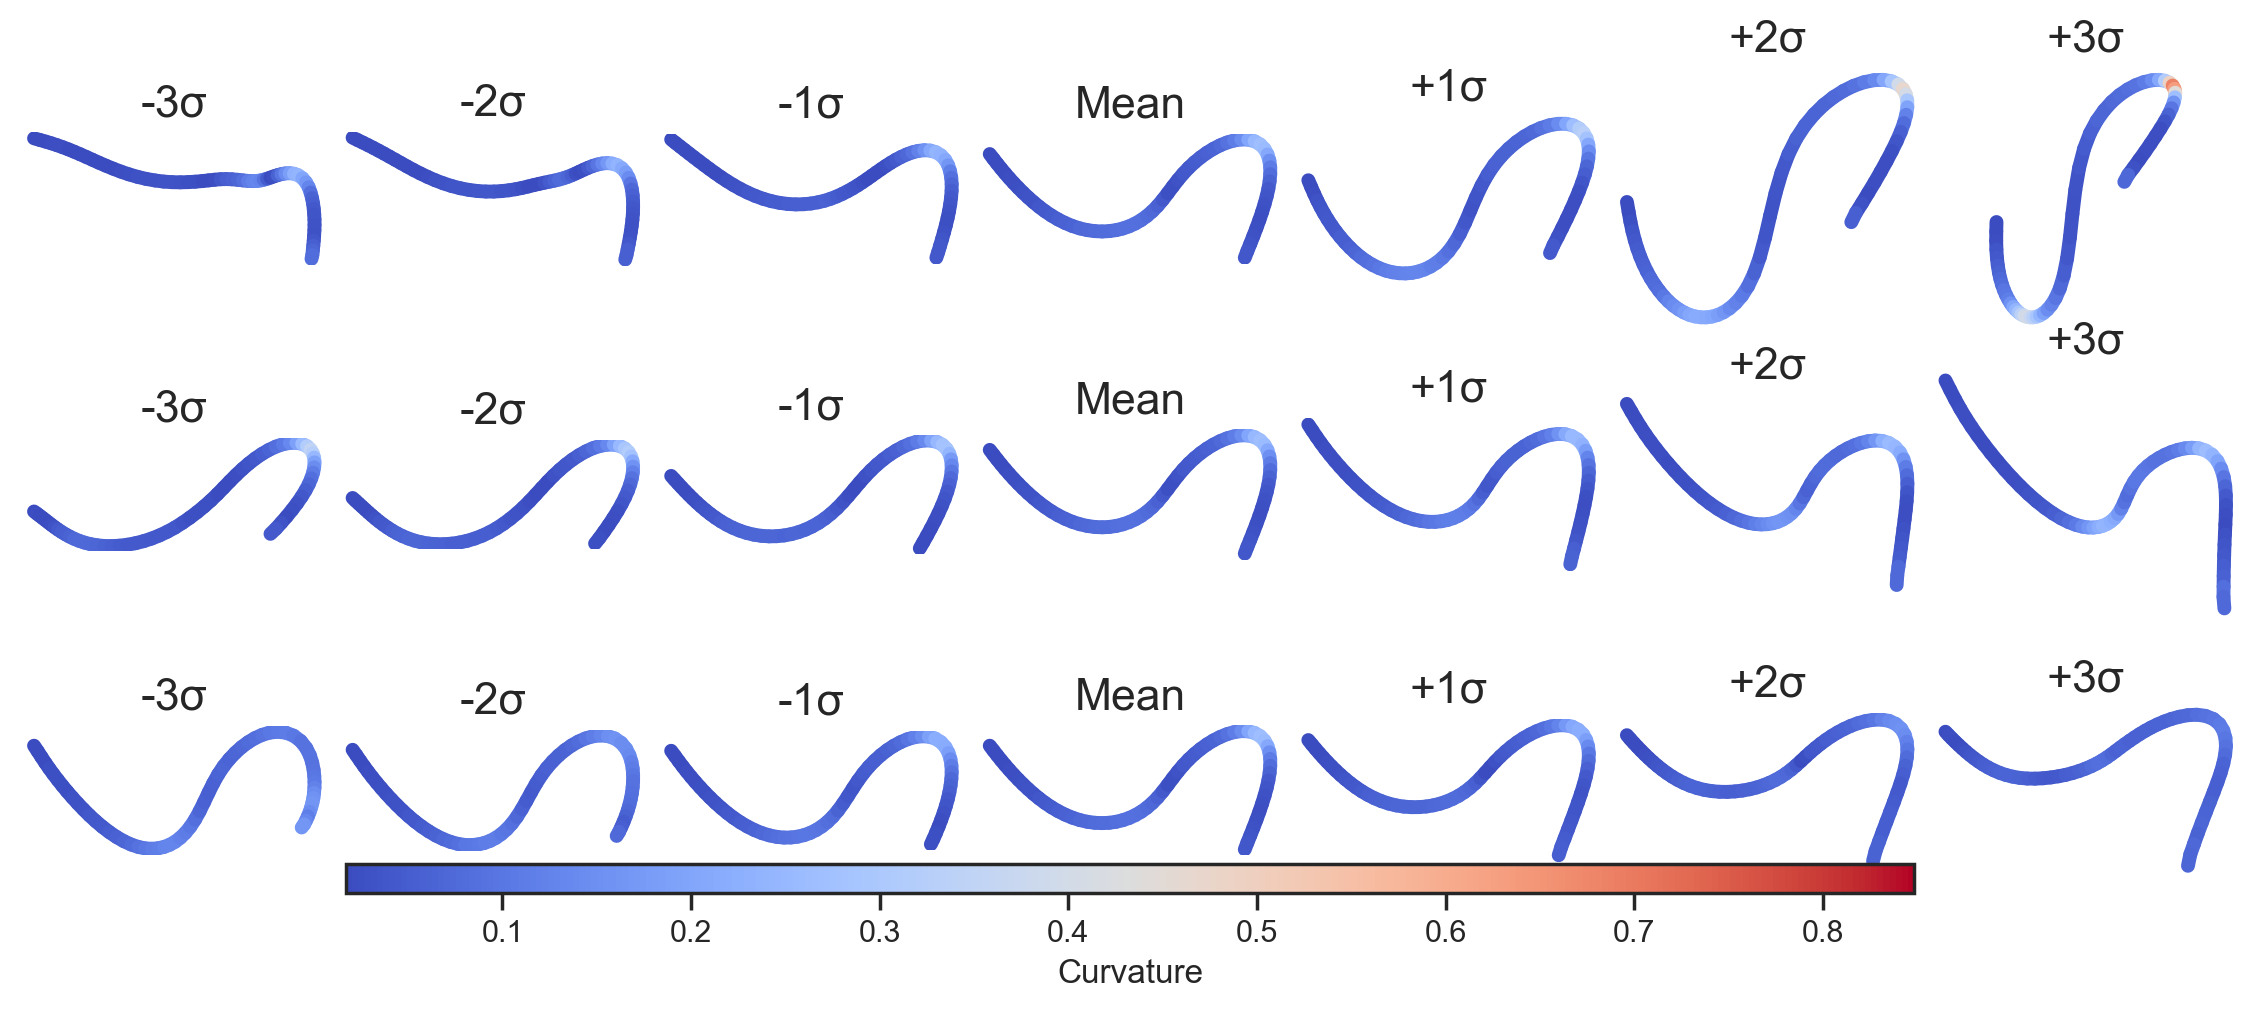

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import PCA

# === 函数：在某个PC方向上做 ±σ 重建 ===
def reconstruct_along_pc(tpca, base_curve, pc_index, n_std, discrete_curves_space):
    n_points = base_curve.shape[0]
    principal_components = tpca.components_.reshape(
        (tpca.n_components_, n_points, 3)
    )
    std = np.sqrt(tpca.explained_variance_[pc_index])
    pc_vec = principal_components[pc_index]

    curves = []
    for s in n_std:
        for sign in [-1, 1]:
            tangent_vec = sign * s * std * pc_vec
            curve_recon = discrete_curves_space.metric.exp(
                tangent_vec=tangent_vec,
                base_point=base_curve
            )
            curves.append((sign, s, curve_recon))
    return curves

# === 参数 ===
pcs_to_show = [0, 1, 2]   # PC1, PC2, PC3
n_std = [1, 2, 3]         # ±1σ, ±2σ
n_cols = len(n_std)*2 + 1 # 每行的列数
cmap = plt.cm.coolwarm

# === 统一 PCA 投影 ===
all_curves = [mean_curve_aligned]
for pc_idx in pcs_to_show:
    curves = reconstruct_along_pc(
        tpca=aligned_tpca,
        base_curve=mean_curve_aligned,
        pc_index=pc_idx,
        n_std=n_std,
        discrete_curves_space=curves_r3_aligned
    )
    for _, _, C in curves:
        all_curves.append(C)

all_points = np.vstack(all_curves)
pca2d = PCA(n_components=2)
pca2d.fit(all_points)

def project2d(curve):
    return pca2d.transform(curve)

# === 计算所有曲率值，确定全局范围 ===
all_curv_vals = []
for C in all_curves:
    C_rescaled = rescale_curve_to_length(C, target_length=25.0)
    kappa = compute_curvature(C_rescaled)
    all_curv_vals.append(kappa)
all_curv_vals = np.concatenate(all_curv_vals)
vmin, vmax = np.min(all_curv_vals), np.max(all_curv_vals)

# 百分位裁剪
qmin, qmax = np.percentile(all_curv_vals, [2, 98])

# === 四种颜色映射方案 ===
norm_methods = {
    "Percentile (2–98%)": colors.Normalize(vmin=qmin, vmax=qmax),
}

# === 主绘图循环 ===
for norm_name, norm in norm_methods.items():
    fig, axes = plt.subplots(
        nrows=len(pcs_to_show),
        ncols=n_cols,
        figsize=(1.6*n_cols, 1.6*len(pcs_to_show)),
        dpi=200
    )

    for row, pc_idx in enumerate(pcs_to_show):
        ax_row = axes[row] if len(pcs_to_show) > 1 else [axes]

        # 生成该PC的所有曲线
        curves = reconstruct_along_pc(
            tpca=aligned_tpca,
            base_curve=mean_curve_aligned,
            pc_index=pc_idx,
            n_std=n_std,
            discrete_curves_space=curves_r3_aligned
        )

        ordered = sorted(curves, key=lambda x: (x[0], x[1]))
        ordered = [c for c in ordered if c[0] < 0][::-1] + [(0, 0, mean_curve_aligned)] + [c for c in ordered if c[0] > 0]

        for col, (sign, s, C) in enumerate(ordered):
            ax = ax_row[col]
            C_rescaled = rescale_curve_to_length(C, target_length=75.0)
            kappa = compute_curvature(C_rescaled)
            proj = project2d(C_rescaled)

            # 按曲率画彩色线
            for i in range(len(proj)-1):
                color = cmap(norm(kappa[i]))
                ax.plot(proj[i:i+2,0], proj[i:i+2,1], color=color, lw=5)

            # 标题
            if s == 0:
                ax.set_title("Mean", fontsize=16)
            else:
                ax.set_title(f"{'+' if sign>0 else '-'}{s}σ", fontsize=16)

            ax.axis("off")
            ax.set_aspect("equal")

        ax_row[0].set_ylabel(f"PC{pc_idx+1}", fontsize=9, rotation=0, labelpad=20, weight="bold")

    # 统一 colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # 在底部预留空间并添加横向 colorbar
    plt.subplots_adjust(bottom=0.10)                 # 给底部留出 18% 空间
    cax = fig.add_axes([0.15, 0.04, 0.70, 0.03])     # [left, bottom, width, height]
    fig.colorbar(sm, cax=cax, orientation='horizontal', label="Curvature")


    # fig.suptitle(norm_name, fontsize=12, weight="bold")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3, rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\cheno\AppData\Local\Temp\ipykernel_34208\3546200158.py:69: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



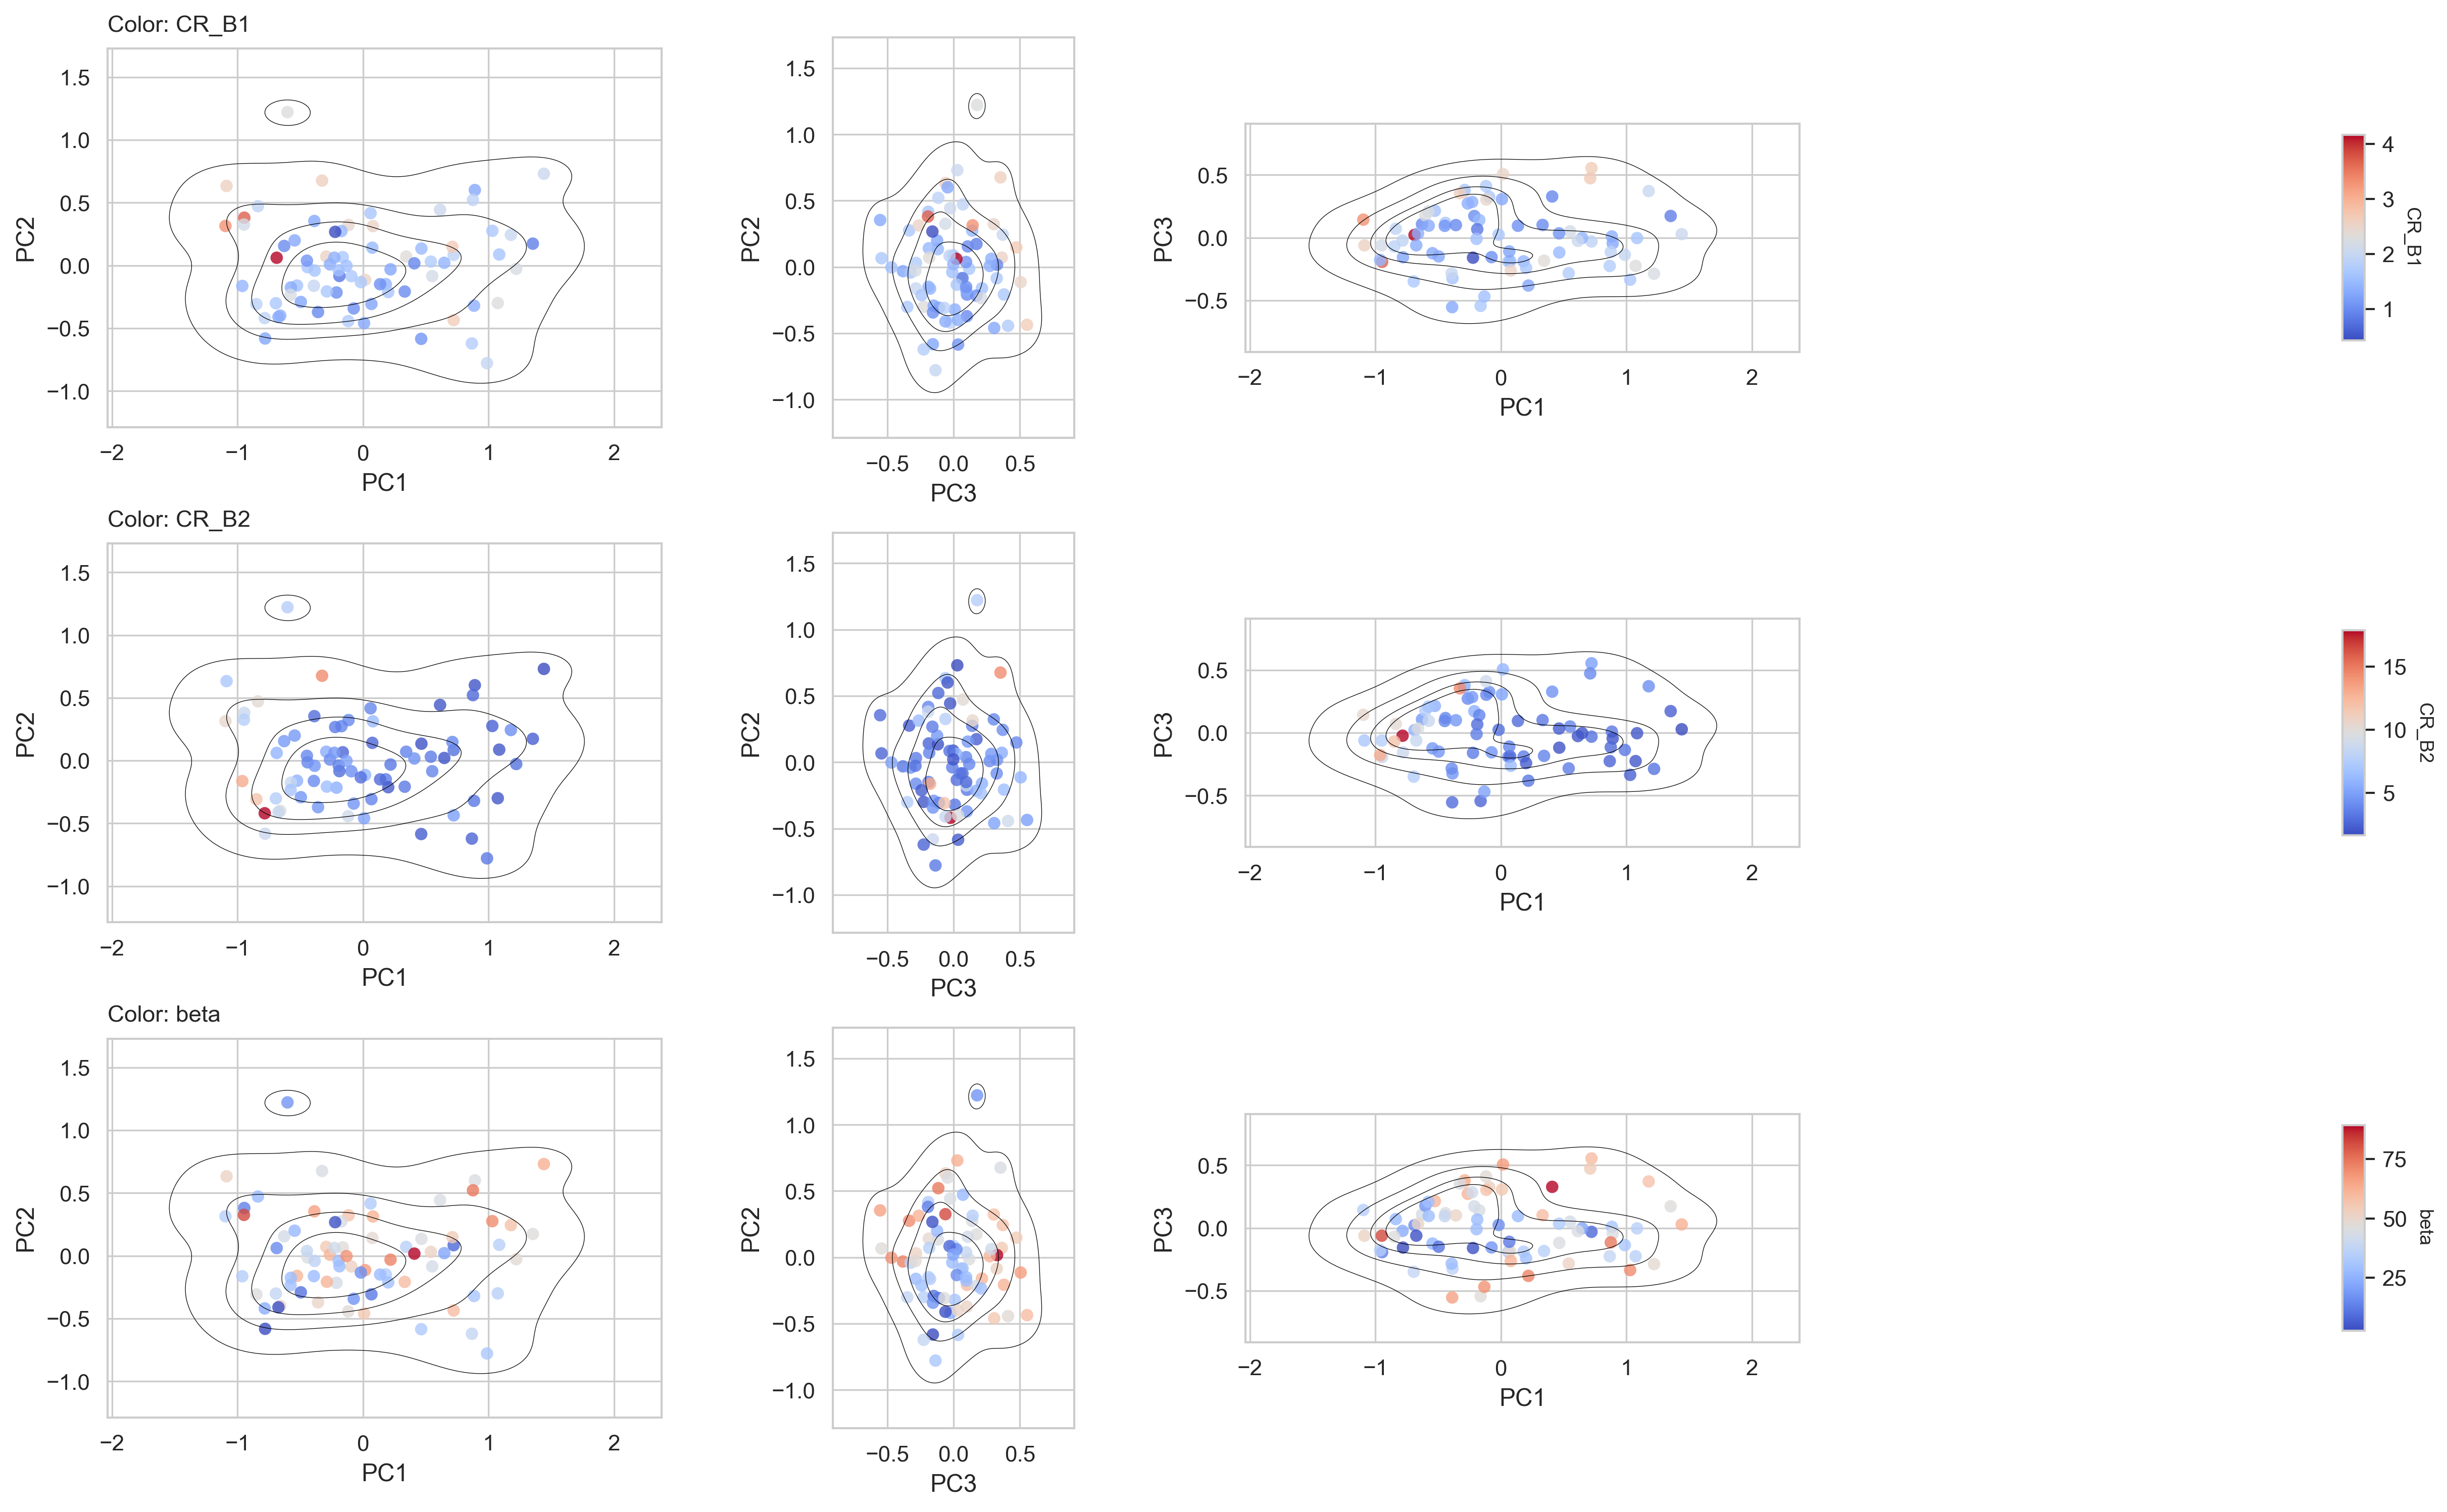

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

palette_name = 'coolwarm'

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# === Step 1. 组装 DataFrame ===
df_pca = pd.DataFrame(aligned_projected_data[:, :3], columns=["PC1", "PC2", "PC3"])
df_pca["filename"] = curves0_names

category_info = []
for name in curves0_names:
    info = vtk_data_dict[name].get("category_info", {})
    category_info.append({
        "CR_B1": info.get("CR_B1", np.nan),
        "CR_B2": info.get("CR_B2", np.nan),
        "beta":  info.get("beta",  np.nan)
    })

df_cat = pd.DataFrame(category_info)
df = pd.concat([df_pca, df_cat], axis=1)

# === Step 2. 绘图配置 ===
pairs = [("PC1", "PC2"), ("PC3", "PC2"), ("PC1", "PC3")]
color_vars = ["CR_B1", "CR_B2", "beta"]

fig, axes = plt.subplots(len(color_vars), len(pairs), figsize=(12, 10), dpi=300)

# === Step 3. 绘制散点 + KDE + colorbar ===
for row_idx, color_var in enumerate(color_vars):
    vmin = np.nanmin(df[color_var])
    vmax = np.nanmax(df[color_var])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for col_idx, (x, y) in enumerate(pairs):
        ax = axes[row_idx, col_idx]
        sns.scatterplot(
            x=x, y=y, data=df,
            hue=color_var, hue_norm=norm,
            palette=palette_name, s=35, alpha=0.8, edgecolor="none",
            ax=ax, legend=False
        )
        sns.kdeplot(x=x, y=y, data=df, levels=5, color="black", linewidths=0.3, ax=ax)
        ax.set_xlabel(x); ax.set_ylabel(y); ax.set_aspect("equal")

        if col_idx == 0:
            ax.set_title(f"Color: {color_var}", loc="left", fontsize=11, pad=8)

    # 在该行最后一个子图右侧嵌入 colorbar
    ax_for_cbar = axes[row_idx, -1]
    cax = inset_axes(
        ax_for_cbar,
        width="4%", height="90%",
        loc="center right",
        bbox_to_anchor=(1.02, 0., 1, 1),
        bbox_transform=ax_for_cbar.transAxes,
        borderpad=0
    )
    sm = mpl.cm.ScalarMappable(cmap=palette_name, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.set_ylabel(color_var, rotation=270, labelpad=12, fontsize=9)

plt.tight_layout()
plt.show()


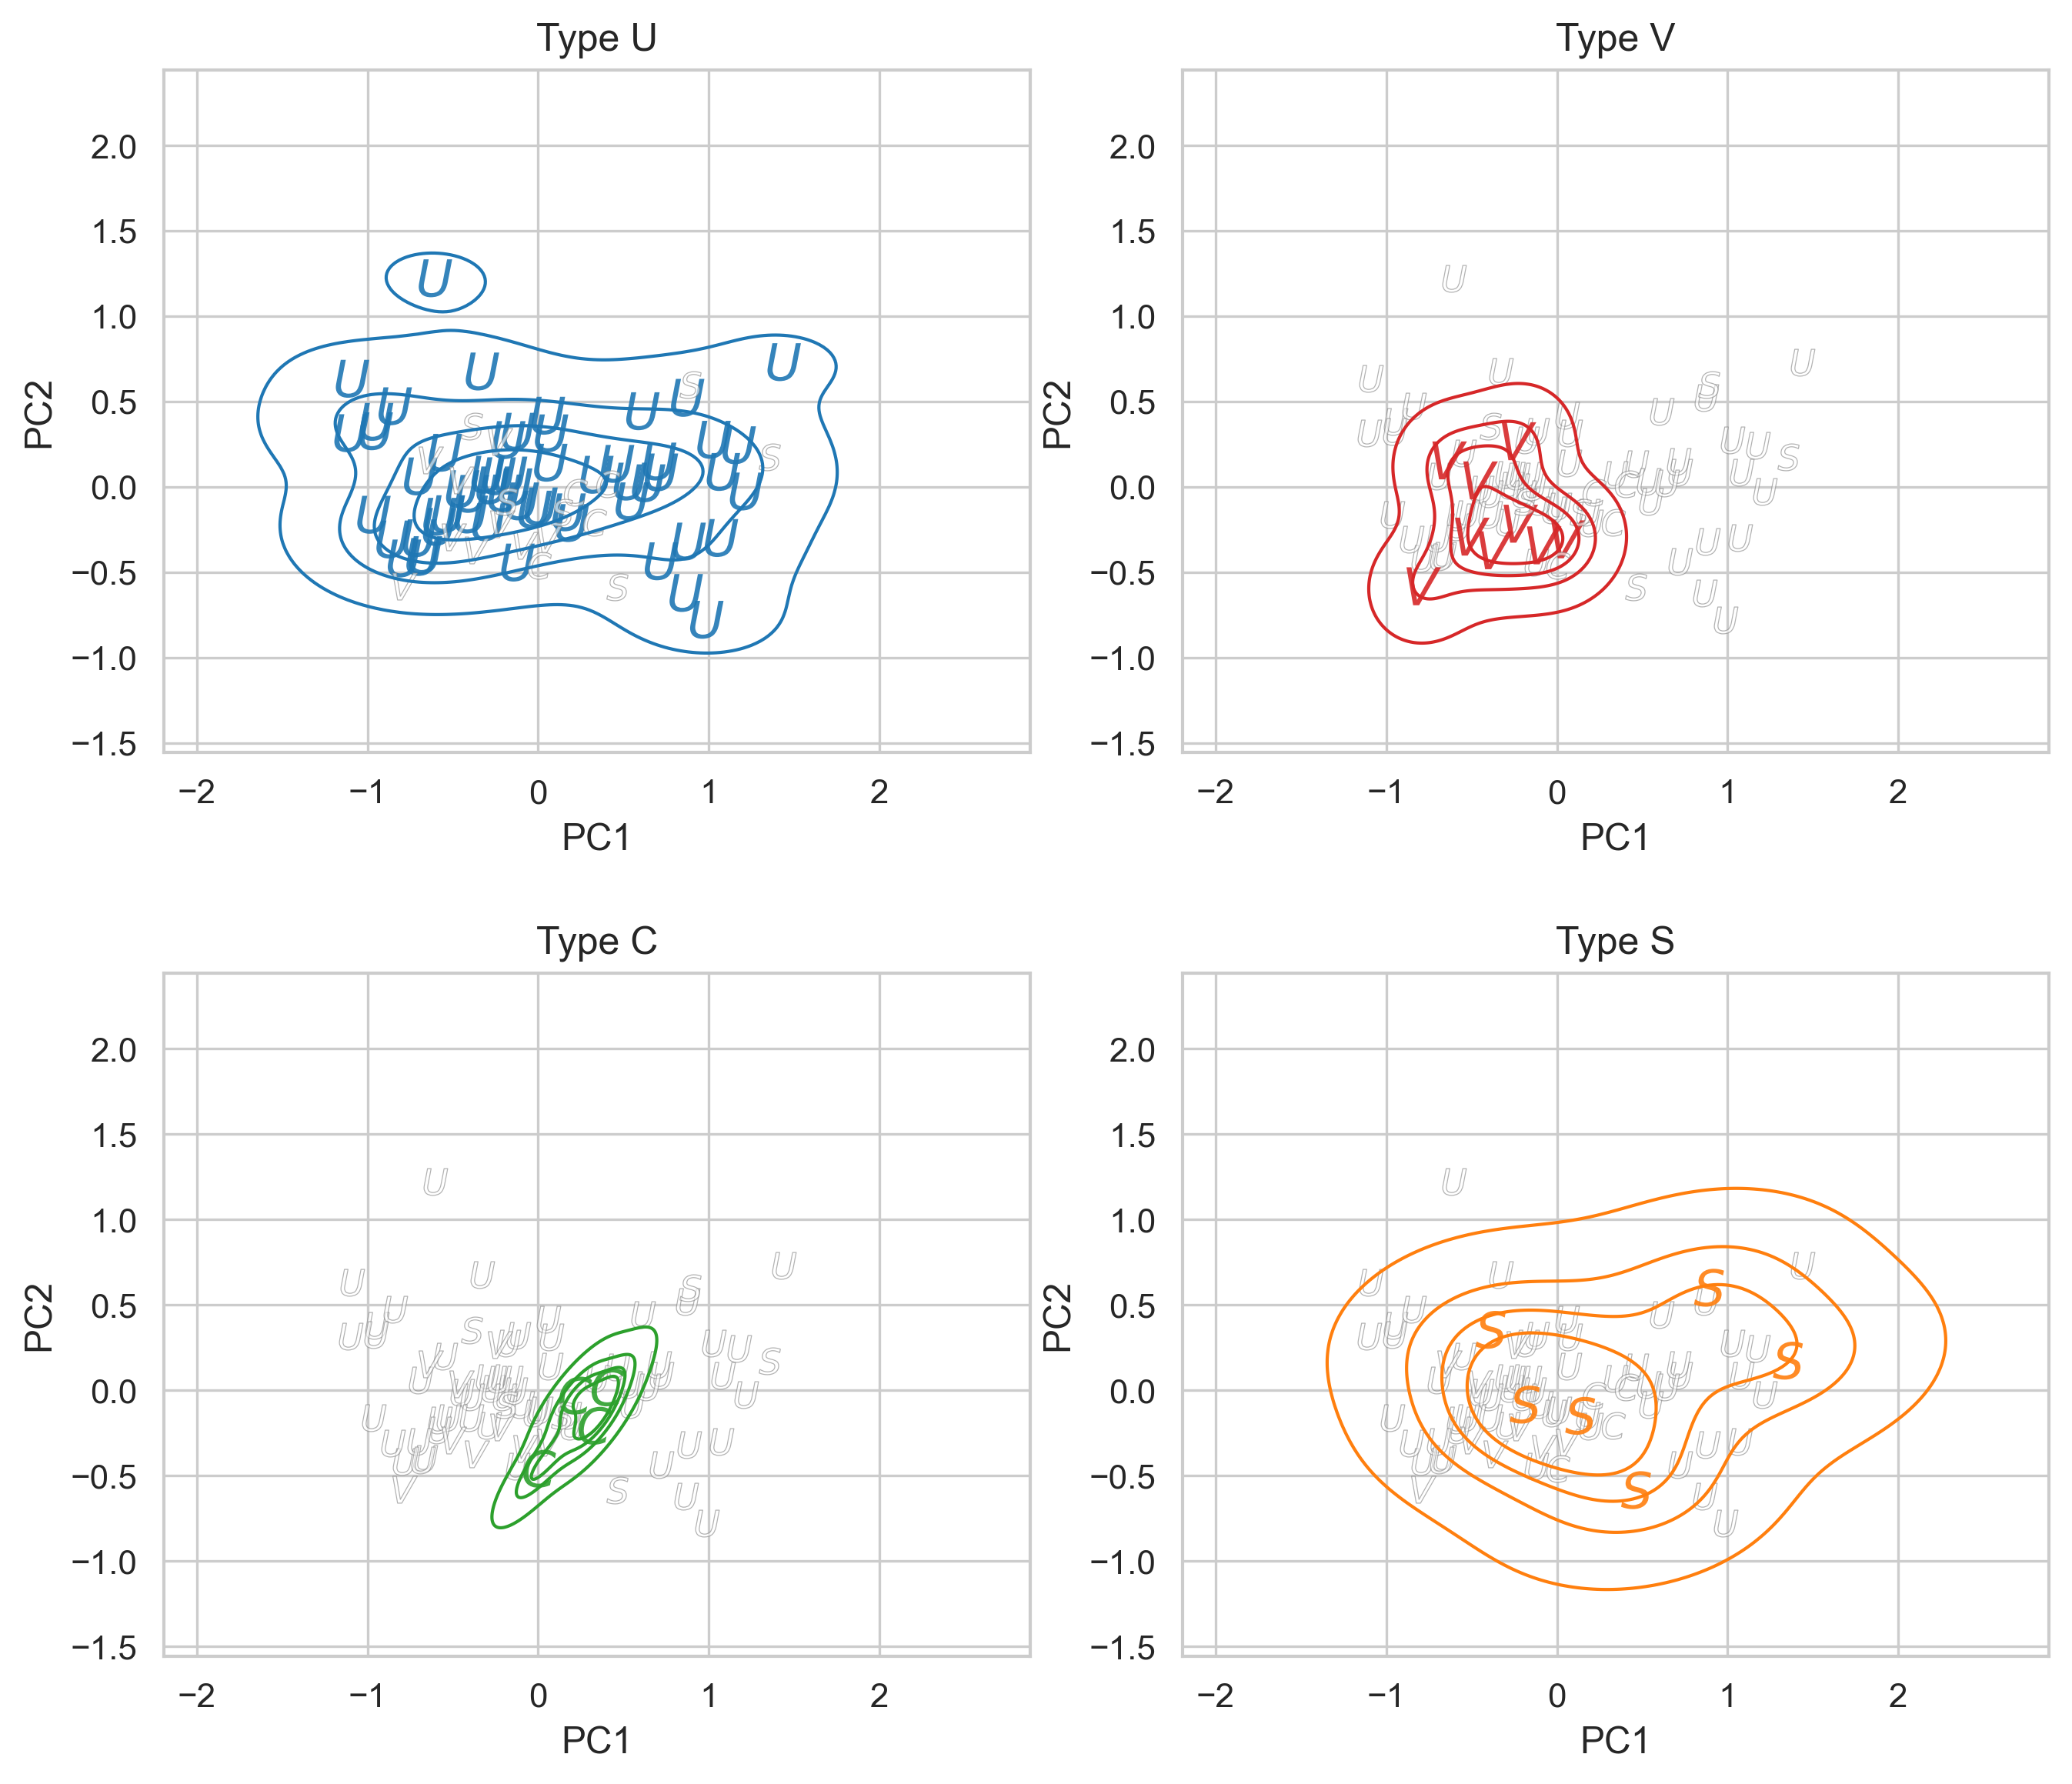

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === 构建 DataFrame ===
df_pca = pd.DataFrame(aligned_projected_data[:, :3], columns=["PC1", "PC2", "PC3"])
df_pca["filename"] = curves0_names
df_pca["Type"] = [
    vtk_data_dict[name].get("category_info", {}).get("Type", "Unknown")
    for name in curves0_names
]

# 颜色映射表
type_colors = {"U": "#1f77b4", "V": "#d62728", "C": "#2ca02c", "S": "#ff7f0e"}
types = ["U", "V", "C", "S"]

# === 绘图 ===
fig, axes = plt.subplots(2, 2, figsize=(9, 8), dpi=300)
axes = axes.ravel()

for i, t in enumerate(types):
    ax = axes[i]
    mask = df_pca["Type"] == t

    # 绘制所有类型（背景白）
    for other_t in types:
        other_mask = df_pca["Type"] == other_t
        color = "white" if other_t != t else type_colors[t]
        size = 140 if other_t == t else 70
        alpha = 0.9 if other_t == t else 0.6
        ax.scatter(
            df_pca.loc[other_mask, "PC1"],
            df_pca.loc[other_mask, "PC2"],
            marker=f"${other_t}$",
            s=size,
            c=color,
            edgecolors="gray" if other_t != t else "none",
            linewidths=0.3,
            alpha=alpha,
        )

    # 绘制目标类型密度等高线
    sns.kdeplot(
        x="PC1", y="PC2", data=df_pca.loc[mask],
        levels=5, color=type_colors[t],
        linewidths=1.0, ax=ax
    )

    ax.set_title(f"Type {t}", fontsize=12)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.set_xlim(df_pca["PC1"].min()*2, df_pca["PC1"].max()*2)
    ax.set_ylim(df_pca["PC2"].min()*2, df_pca["PC2"].max()*2)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


In [82]:
import numpy as np
import json

# 确保数据长度匹配
n_samples = len(curves0_names)
assert aligned_projected_data.shape[0] == n_samples, "PCA 行数与样本数量不匹配"

# 限制到前五个主成分
pc_labels = [f"PC{i+1}" for i in range(min(8, aligned_projected_data.shape[1]))]

# 构建导出字典
export_dict = {}
for i, name in enumerate(curves0_names):
    pcs = {pc_labels[j]: float(aligned_projected_data[i, j]) for j in range(len(pc_labels))}
    export_dict[name] = {
        "aligned_centerline": aligned_final_dict[name].tolist(), 
        "pcs": pcs
    }

import os
import json

# === 新的输出文件夹 ===
outdir = "exported_PCs_siphon"          # 你想要的新文件夹名
os.makedirs(outdir, exist_ok=True)  # 若不存在就自动创建

# === 文件路径 ===
out_path = os.path.join(outdir, "siphon_aligned_with_PCs.json")

# === 保存你的结果字典 ===
with open(out_path, "w") as f:
    json.dump(export_dict, f, indent=2)

print(f"✅ Saved to new folder: {out_path}")


✅ Saved to new folder: exported_PCs_siphon\siphon_aligned_with_PCs.json


In [83]:
import plotly.graph_objects as go

# === 1) 准备类型与颜色 ===
type_colors = {"U": "#1f77b4", "V": "#d62728", "C": "#2ca02c", "S": "#ff7f0e", "Unknown": "#999999"}

# 收集每条曲线的 Type
curve_types = {}
for name in aligned_final_dict.keys():
    info = vtk_data_dict.get(name, {}).get("category_info", {})  # 兼容没有category_info的情况
    t = info.get("Type", "Unknown")
    if t not in type_colors:
        t = "Unknown"
    curve_types[name] = t

# 实际出现过的类型（保持有序）
present_types = []
for t in ["U", "V", "C", "S", "Unknown"]:
    if any(tp == t for tp in curve_types.values()):
        present_types.append(t)

# === 2) 建图：每条曲线一条 trace + 额外加一条 Mean 曲线 ===
fig = go.Figure()
trace_type = []   # 记录每个trace的类别（不含均值）
trace_names = []  # 记录trace对应的曲线名（不含均值）

for name, t in curve_types.items():
    C = aligned_final_dict[name]
    fig.add_trace(go.Scatter3d(
        x=C[:, 0], y=C[:, 1], z=C[:, 2],
        mode="lines",
        line=dict(width=2, color=type_colors[t]),
        name=f"{t} — {name}",
        hoverinfo="name",
        showlegend=False
    ))
    trace_type.append(t)
    trace_names.append(name)

# 添加均值曲线（最后一个trace，按钮里始终保持可见）
mean_idx = len(fig.data)
fig.add_trace(go.Scatter3d(
    x=mean_curve[:, 0], y=mean_curve[:, 1], z=mean_curve[:, 2],
    mode="lines",
    line=dict(width=6, color="black"),
    name="Mean curve",
    showlegend=True
))

# === 3) 下拉菜单：构造不同按钮的可见性数组 ===
def vis_mask_for(filter_type):
    """
    返回一个长度==len(fig.data) 的布尔可见性列表。
    最后一条是 mean 曲线 -> 始终 True。
    其他曲线：当 filter_type == 'All' 时全 True；否则仅该类型 True。
    """
    n_curve_traces = len(fig.data) - 1
    if filter_type == "All":
        mask = [True]*n_curve_traces
    else:
        mask = [ (t == filter_type) for t in trace_type ]
    mask.append(True)  # mean curve
    return mask

buttons = []
# All
buttons.append(dict(
    label="All",
    method="update",
    args=[{"visible": vis_mask_for("All")}],
))
# 每个出现过的类型
for t in present_types:
    buttons.append(dict(
        label=t,
        method="update",
        args=[{"visible": vis_mask_for(t)}],
    ))

# === 4) 再加一个“图例颜色示意”的空trace（每类一个），便于读图 ===
# （这些只占图例，不在按钮里切换，不影响显示）
for t in present_types:
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode="lines",
        line=dict(width=4, color=type_colors[t]),
        name=f"Type {t}",
        showlegend=True
    ))
# 注意：这些图例trace默认可见；如果想让按钮也控制它们，可把它们纳入vis_mask_for逻辑

# === 5) 布局 ===
fig.update_layout(
    title="Aligned Curves by Type — interactive filter",
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data"
    ),
    legend=dict(
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=0.5
    ),
    height=720, width=980,
    updatemenus=[dict(
        type="dropdown",
        x=1.02, y=1.0, xanchor="left", yanchor="top",
        buttons=buttons,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="gray", borderwidth=0.5,
        showactive=True
    )]
)

fig.show()
# 假设你已经有 fig 对象
fig.write_html("aligned_by_type.html", include_plotlyjs=True, auto_open=True)

In [84]:
import numpy as np
import os
import vtk
from vtk.util import numpy_support

# ==========================================
# 1. 工具函数 (直接复用你的逻辑)
# ==========================================

def rescale_curve_to_length(curve, target_length=75.0):
    """ 将曲线缩放到指定物理长度 """
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    length = np.sum(seg_lengths)
    if length < 1e-6: return curve # 防止除以0
    scale = target_length / length
    return curve * scale

def save_vtk_polydata(coords, filepath):
    """ 保存为 VTK 文件 """
    points = vtk.vtkPoints()
    points.SetData(numpy_support.numpy_to_vtk(coords, deep=True))
    lines = vtk.vtkCellArray()
    lines.InsertNextCell(len(coords))
    for i in range(len(coords)):
        lines.InsertCellPoint(i)
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(points)
    polydata.SetLines(lines)
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filepath)
    writer.SetInputData(polydata)
    writer.Write()

# ==========================================
# 2. 核心生成逻辑 (仿照 reconstruct_along_pc)
# ==========================================

def generate_synthetic_shapes_by_type(
    target_type, 
    n_samples, 
    tpca, 
    base_curve, 
    metric_space, 
    projected_data, 
    names_list, 
    length_df,
    output_dir="synthetic_results"
):
    print(f"\n>>> Processing Type: {target_type}")
    os.makedirs(output_dir, exist_ok=True)

    # --- A. 准备组件 (Components) ---
    # 模仿 reconstruct_along_pc: 将扁平的 components 重塑为 (n_comps, n_points, 3)
    n_points = base_curve.shape[0]
    n_components = tpca.n_components_
    
    # 这里的 shape 应该是 (10, 100, 3)
    principal_components = tpca.components_.reshape((n_components, n_points, 3))

    # --- B. 获取该 Type 的分布统计 (Statistics) ---
    # 1. 找到索引
    indices = []
    for i, name in enumerate(names_list):
        # 注意：这里需要依赖外部的 vtk_data_dict，或者假设 names_list 和 projected_data 是一一对应的
        info = vtk_data_dict[name].get("category_info", {})
        if info and info.get("Type") == target_type:
            indices.append(i)
    
    if not indices:
        print(f"Warning: No samples found for Type {target_type}")
        return

    # 2. 提取系数并计算均值/协方差
    # 只取前 n_components 个系数 (通常就是 projected_data 的列数)
    type_scores = projected_data[indices, :n_components]
    
    mu_vec = np.mean(type_scores, axis=0)
    cov_mat = np.cov(type_scores, rowvar=False)

    # 防止奇异矩阵 (如果样本很少)
    if len(indices) <= n_components:
        cov_mat += np.eye(n_components) * 1e-5

    # --- C. 采样 (Sampling) ---
    # 生成 n_samples 个新的系数向量，每个向量长度为 n_components
    synthetic_scores = np.random.multivariate_normal(mu_vec, cov_mat, n_samples)

    # --- D. 获取目标物理长度 ---
    # 从 dataframe 中查平均长度
    avg_len = length_df[length_df["Type"] == target_type]["Length"].mean()
    print(f"  - Target Length: {avg_len:.2f} mm")
    print(f"  - Generating {n_samples} samples...")

    # --- E. 重建循环 (Reconstruction Loop) ---
    for i in range(n_samples):
        scores = synthetic_scores[i] # 一个 (10,) 的向量
        
        # 1. 构建切向量 (Manual Inverse Transform)
        # Tangent_Vec = sum( score_j * Component_j )
        # 利用 broadcasting: (10, 1, 1) * (10, 100, 3) -> sum axis 0 -> (100, 3)
        tangent_vec = np.sum(
            scores[:, np.newaxis, np.newaxis] * principal_components, 
            axis=0
        )
        
        # 2. 指数映射 (Exponential Map)
        # 将切向量映射回弯曲空间
        curve_recon = metric_space.metric.exp(
            tangent_vec=tangent_vec,
            base_point=base_curve
        )
        
        # 3. 恢复尺度 (Rescaling)
        curve_final = rescale_curve_to_length(curve_recon, target_length=avg_len)
        
        # 4. 保存
        fname = f"Gen_{target_type}_{i+1:02d}.vtk"
        save_vtk_polydata(curve_final, os.path.join(output_dir, fname))

    print(f"  - Done. Saved to {output_dir}")

# ==========================================
# 3. 执行
# ==========================================

target_types = ["V", "C"]  # 你想要生成的类型
num_gen = 10               # 生成数量

for t in target_types:
    generate_synthetic_shapes_by_type(
        target_type=t,
        n_samples=num_gen,
        tpca=aligned_tpca,                 # 你的 tPCA 对象
        base_curve=mean_curve_aligned,     # 你的平均形状
        metric_space=curves_r3_aligned,    # 你的流形空间定义
        projected_data=aligned_projected_data, # 所有数据的 PC 系数
        names_list=curves0_names,          # 文件名列表
        length_df=df_lengths               # 长度统计表
    )


>>> Processing Type: V
  - Target Length: 23.22 mm
  - Generating 10 samples...
  - Done. Saved to synthetic_results

>>> Processing Type: C
  - Target Length: 23.91 mm
  - Generating 10 samples...
  - Done. Saved to synthetic_results


In [85]:
# Carlos MASTER THESIS RESULTS

case_name_U = ['BG0011_L_siphon_lab.vtk','BG0018_L_siphon_lab.vtk']
case_name_V = ['BH0017_R_siphon_lab.vtk','BH0031_L_siphon_lab.vtk']
case_name_C = ['BH0006_L_siphon_lab.vtk']#,'BH0003_R_siphon_lab.vtk']

for case_name in case_name_U + case_name_V + case_name_C:
    # for case_name in case_name_list:
    print (case_name)
    print (vtk_data_dict[case_name]['category_info'])
    print (export_dict[case_name]['pcs'])

BG0011_L_siphon_lab.vtk
{'CR_B1': 2.0637, 'CR_B2': 1.6201, 'beta': 61.96, 'Type': 'U'}
{'PC1': 1.440962477473104, 'PC2': 0.730680860955359, 'PC3': 0.028020378575614183, 'PC4': 0.18301543416394367, 'PC5': -0.11107766431540582, 'PC6': -0.09204990847519849, 'PC7': 0.02189956461654288, 'PC8': -0.009388267875637051}
BG0018_L_siphon_lab.vtk
{'CR_B1': 1.6568, 'CR_B2': 2.058, 'beta': 35.25, 'Type': 'U'}
{'PC1': 1.0850768928690604, 'PC2': 0.08738078579499375, 'PC3': -0.0032574555103676273, 'PC4': 0.026778131720538983, 'PC5': 0.015606341948993012, 'PC6': 0.07127591482459186, 'PC7': -0.14630841075333775, 'PC8': -0.009377334451380547}
BH0017_R_siphon_lab.vtk
{'CR_B1': 2.2204, 'CR_B2': 6.8383, 'beta': 29.18, 'Type': 'U'}
{'PC1': -0.5768570432046807, 'PC2': -0.23444450056478597, 'PC3': 0.20776502900442473, 'PC4': 0.19259018831301394, 'PC5': -0.1087826662842495, 'PC6': 0.04084642909389716, 'PC7': 0.023485545343657325, 'PC8': 0.03953659409917986}
BH0031_L_siphon_lab.vtk
{'CR_B1': 1.3385, 'CR_B2': 8.54

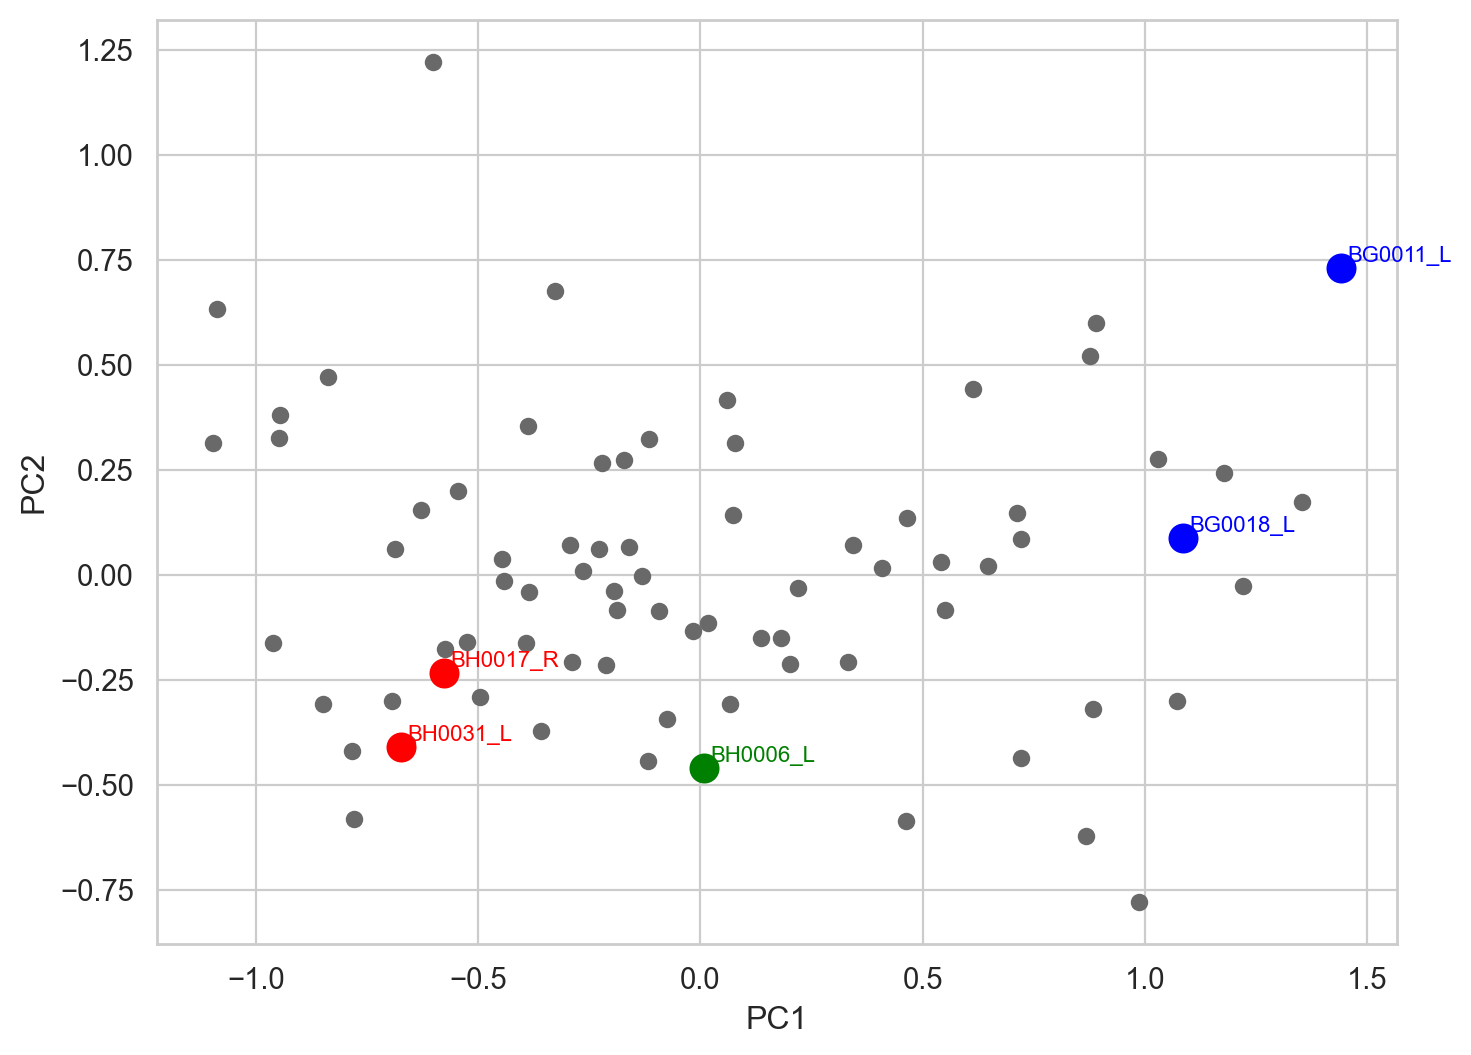

In [86]:
fig = plt.figure(figsize=(8,6), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(df_pca['PC1'], df_pca['PC2'], c='dimgray', s=30, label='All samples')
for case_name in case_name_U:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='blue', s=100, label=f'Case U: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='blue')
for case_name in case_name_V:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='red', s=100, label=f'Case V: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='red')
for case_name in case_name_C:
    ax.scatter(df_pca.loc[df_pca['filename']==case_name, 'PC1'],
               df_pca.loc[df_pca['filename']==case_name, 'PC2'],
               c='green', s=100, label=f'Case C: {case_name}')
    ax.text(df_pca.loc[df_pca['filename']==case_name, 'PC1'].values[0]+0.015,
            df_pca.loc[df_pca['filename']==case_name, 'PC2'].values[0]+0.015,
            case_name[:-15], fontsize=8, color='green')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()
